In [1]:
import pandas as pd
import datetime
import ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
import numpy as np
from scipy import stats
from scipy.stats import linregress, pearsonr
from scipy.stats import f
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Historical Trend of Copper/Aluminum

In [2]:
copper_monthly = pd.read_csv("resources/copper_monthly.csv")
alu_monthly = pd.read_csv("resources/alu_monthly.csv")

In [3]:
copper_monthly.head()

date             value
0  2024-11-01  9075.72714285714
1  2024-10-01  9533.99130434783
2  2024-09-01  9259.12857142857
3  2024-08-01  8981.11772727273
4  2024-07-01  9385.31304347826

In [4]:
copper_monthly = copper_monthly.rename(columns = {"value":"copper_value"})
copper_monthly.head()

date      copper_value
0  2024-11-01  9075.72714285714
1  2024-10-01  9533.99130434783
2  2024-09-01  9259.12857142857
3  2024-08-01  8981.11772727273
4  2024-07-01  9385.31304347826

In [5]:
alu_monthly.head()

date             value
0  2024-11-01  2582.18857142857
1  2024-10-01  2595.58304347826
2  2024-09-01   2457.4780952381
3  2024-08-01  2352.46727272727
4  2024-07-01   2349.1252173913

In [6]:
alu_monthly = alu_monthly.rename(columns = {"value":"alu_value"})

In [7]:
alu_monthly = alu_monthly.drop(columns=['date'], axis=1)

In [8]:
combined_monthly = pd.concat([copper_monthly, alu_monthly], axis=1)
combined_monthly.head()

date      copper_value         alu_value
0  2024-11-01  9075.72714285714  2582.18857142857
1  2024-10-01  9533.99130434783  2595.58304347826
2  2024-09-01  9259.12857142857   2457.4780952381
3  2024-08-01  8981.11772727273  2352.46727272727
4  2024-07-01  9385.31304347826   2349.1252173913

In [9]:
combined_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          539 non-null    object
 1   copper_value  539 non-null    object
 2   alu_value     539 non-null    object
dtypes: object(3)
memory usage: 12.8+ KB


In [10]:
combined_monthly['copper_value'] = pd.to_numeric(combined_monthly['copper_value'], errors='coerce')
combined_monthly['alu_value'] = pd.to_numeric(combined_monthly['alu_value'], errors='coerce')

combined_monthly['date'] = pd.to_datetime(combined_monthly['date'])


In [11]:
combined_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          539 non-null    datetime64[ns]
 1   copper_value  419 non-null    float64       
 2   alu_value     419 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 12.8 KB


In [12]:
combined_monthly = combined_monthly.dropna()
combined_monthly.tail()

date  copper_value  alu_value
414 1990-05-01   2740.342391     1527.0
415 1990-04-01   2685.226891     1526.0
416 1990-03-01   2625.702723     1567.0
417 1990-02-01   2358.943400     1454.0
418 1990-01-01   2365.556991     1528.0

In [13]:
# Correlation between copper and aluminium (starting from 1990 Jan - 2024 Nov) 
corr_matrix = combined_monthly.drop(columns=['date']).corr()
corr_matrix

copper_value  alu_value
copper_value      1.000000   0.846464
alu_value         0.846464   1.000000

In [149]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=combined_monthly['date'], y=combined_monthly['copper_value'], mode='lines', name='Global Copper Price'))
fig.add_trace(go.Scatter(x=combined_monthly['date'], y=combined_monthly['alu_value'], mode='lines', name='Global Aluminium Price'))

fig.update_layout(
    title='Global Copper & Aluminium Price (From 1990-Jan to 2024-Nov)',
    xaxis_title='Date',
    yaxis_title='Monthly Price (USD/Metric Ton)',
    legend=dict(x=1, y=1),
    template='plotly_white',
)

fig.show()

# 2. Consumer Price Index (CPI)
---
- **2.1 Comparison of CPI and PCE measures**
- **2.2 CPI v.s. Copper/Aluminum**

In [15]:
cpi_df = pd.read_csv("resources/fredgraph_2014Nov_2024Nov.csv")

In [16]:
cpi_df.tail()

observation_date  CPIAUCSL_PC1  CPILFESL_PC1  CPIENGSL_PC1  \
116       2024-07-01       2.92357       3.21319       0.96254   
117       2024-08-01       2.59123       3.26556      -4.01051   
118       2024-09-01       2.40751       3.25871      -6.85852   
119       2024-10-01       2.57633       3.30004      -4.84854   
120       2024-11-01       2.73258       3.30015      -3.14935   

     CUSR0000SACE_PC1  CUSR0000SEHF_PC1  PCEPI_PC1  
116          -2.07931           4.12569    2.46853  
117         -10.15275           3.03405    2.28331  
118         -15.31385           3.35753    2.10237  
119         -12.39927           4.00513    2.30767  
120          -8.45783           2.83076    2.44368

In [17]:
cpi_df = cpi_df.rename(columns = {"CPIAUCSL_PC1":"CPI_all_items","PCEPI_PC1":"PCE",
                                  "CPIENGSL_PC1":"CPI_Energy",
                                  "CUSR0000SACE_PC1":"CPI_Energy_Commo","CUSR0000SEHF_PC1":"CPI_Energy_Ser",
                                  "CPIENGSL_PC1":"CPI_Energy",
                                  "observation_date":"Date","CPILFESL_PC1":"CPI_excl_food_energy"})

cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])

cpi_df.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2014-11-01        1.23152               1.74159    -5.64523   
1 2014-12-01        0.65312               1.62242   -11.06770   
2 2015-01-01       -0.22993               1.63163   -20.13821   
3 2015-02-01       -0.08703               1.68808   -18.76723   
4 2015-03-01       -0.02203               1.74538   -17.68436   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE  
0         -11.36293         2.86334  1.08576  
1         -20.82224         3.71750  0.73226  
2         -34.59511         1.66763  0.04140  
3         -31.93502         0.81750  0.17070  
4         -28.07911        -2.93954  0.19935

In [18]:
cpi_df.to_csv("outputs/cpi_2014Nov_2024Nov.csv", index=False)

## 2.1 Comparison of CPI and PCE measures

In [19]:
legend_labels = {
    'CPI_all_items': 'Headline CPI',
    'CPI_excl_food_energy': 'Core CPI',
    'PCE': 'PCE',
    'CPI_Energy': 'Energy CPI',
    'CPI_Energy_Commo': 'CPI - Energy Commodities',
    'CPI_Energy_Ser': 'CPI - Energy Services',
}

fig = go.Figure()

columns_to_plot = ['CPI_all_items','CPI_excl_food_energy', 'PCE', 'CPI_Energy', 'CPI_Energy_Commo', 'CPI_Energy_Ser']

for column in columns_to_plot:
    fig.add_trace(go.Scatter(
        x=cpi_df['Date'],
        y=cpi_df[column],
        mode='lines',
        name=legend_labels.get(column, column),
        line=dict(
            width=4 if column == 'CPI_all_items' else 2,

        ),
        opacity=1.0 if column == 'CPI_all_items' else 0.6 
    ))


fig.update_layout(
    title='Comparison of CPI and PCE Measures',
    xaxis_title='Date',
    yaxis_title='Year-over-Year % Change',
    showlegend=True,
    template='plotly_white'
)


fig.show()

In [20]:
stats_cpi_df = cpi_df.describe()
stats_cpi_df

CPI_all_items  CPI_excl_food_energy  CPI_Energy  CPI_Energy_Commo  \
count     121.000000            121.000000  121.000000        121.000000   
mean        2.848103              2.963496    2.165529          2.382161   
std         2.287049              1.515466   14.054251         23.018112   
min        -0.229930              1.179880  -20.138210        -34.595110   
25%         1.373080              1.877700   -7.764240        -15.313850   
50%         2.180570              2.235350    0.026220         -0.971470   
75%         3.323160              3.910120    8.587850         14.294810   
max         8.989740              6.640450   41.563290         60.663670   

       CPI_Energy_Ser         PCE  
count      121.000000  121.000000  
mean         2.953751    2.421926  
std          5.707811    1.896452  
min         -4.806550    0.041400  
25%         -0.504070    1.219770  
50%          1.382680    1.793710  
75%          4.125690    2.994290  
max         19.939010    7.248870

In [21]:
std_cpi_energy = stats_cpi_df.loc['std','CPI_Energy']
std_energy_comm = stats_cpi_df.loc['std','CPI_Energy_Commo']
std_energy_ser = stats_cpi_df.loc['std','CPI_Energy_Ser']
std_headline_cpi = stats_cpi_df.loc['std','CPI_all_items']


var_cpi_energy = std_cpi_energy ** 2
var_headline_cpi = std_headline_cpi ** 2


perc_commodities = (std_energy_comm ** 2 / var_cpi_energy) * 100
perc_services = (std_energy_ser ** 2 / var_cpi_energy) * 100


print(f"Total Variance of CPI Energy: {var_cpi_energy:.3f}")
print(f"Variance of Energy Commodities: {std_energy_comm ** 2:.3f}")
print(f"Variance of Energy Services: {std_energy_ser ** 2:.3f}")
print(f"Percentage Contribution of Energy Commodities: {perc_commodities:.2f}%")
print(f"Percentage Contribution of Energy Services: {perc_services:.2f}%")
print(f"Total Variance of Headline CPI: {var_headline_cpi:.3f}")

Total Variance of CPI Energy: 197.522
Variance of Energy Commodities: 529.833
Variance of Energy Services: 32.579
Percentage Contribution of Energy Commodities: 268.24%
Percentage Contribution of Energy Services: 16.49%
Total Variance of Headline CPI: 5.231


## 2.2 CPI v.s. Copper/Aluminum (Past Decade)
---
- Headline CPI
- Core CPI
- Energy CPI,Energy Service CPI, Energy Commodities CPI
- Personal Consumption Expenditure (PCE)

In [22]:
f_combined_monthly = combined_monthly[(combined_monthly['date'] >= '2014-11-01')&
                                  (combined_monthly['date'] <= '2024-11-01')]

f_combined_monthly.head()

date  copper_value    alu_value
0 2024-11-01   9075.727143  2582.188571
1 2024-10-01   9533.991304  2595.583043
2 2024-09-01   9259.128571  2457.478095
3 2024-08-01   8981.117727  2352.467273
4 2024-07-01   9385.313043  2349.125217

In [23]:
f_combined_monthly = f_combined_monthly.sort_values(by="date",ascending = True).reset_index(drop=True)
f_combined_monthly.head()

date  copper_value    alu_value
0 2014-11-01   6712.850000  2055.555000
1 2014-12-01   6446.452381  1909.459524
2 2015-01-01   5830.535714  1814.719048
3 2015-02-01   5729.275000  1817.820000
4 2015-03-01   5939.670455  1773.863636

In [24]:
def add_trendline(x, y):
    slope, intercept, _, _, _ = linregress(x, y)
    return slope * x + intercept

In [25]:
def plot_comm_vs_cpi(comm_value, comm_label, cpi_value, cpi_label, cpi_df, f_combined_monthly):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=f_combined_monthly['date'], 
        y=f_combined_monthly[comm_value], 
        mode='markers', 
        name=comm_label
    ))

    fig.add_trace(go.Scatter(
        x=f_combined_monthly['date'], 
        y=cpi_df[cpi_value], 
        mode='lines', 
        name=cpi_label, 
        yaxis='y2'
    ))


    f_combined_monthly['date_num'] = f_combined_monthly['date'].map(pd.Timestamp.toordinal)
    
    comm_trendline = add_trendline(f_combined_monthly['date_num'], f_combined_monthly[comm_value])
    fig.add_trace(go.Scatter(
        x=f_combined_monthly['date'], 
        y=comm_trendline, 
        mode='lines', 
        name=f'{comm_label} Trendline', 
        line=dict(dash='dash', color='blue')
    ))

    
    cpi_trendline = add_trendline(f_combined_monthly['date_num'], cpi_df[cpi_value])
    fig.add_trace(go.Scatter(
        x=f_combined_monthly['date'], 
        y=cpi_trendline, 
        mode='lines', 
        name=f'{cpi_label} Trendline', 
        line=dict(dash='dash', color='red'),
        yaxis='y2'
    ))
    
    fig.update_layout(
        title=f'{comm_label} with {cpi_label} (From 2014-Nov to 2024-Nov)',
        xaxis_title='Date',
        yaxis=dict(
            title=f'{comm_label}(USD/Metric Ton)',
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue'),
        ),
        yaxis2=dict(
            title=f'{cpi_label}(YoY % Change)',
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right'
        ),
        legend=dict(x=1.1, y=1),template='plotly_white',
    )

    
    fig.show()

    
    correlation, _ = pearsonr(cpi_df[cpi_value], f_combined_monthly[comm_value])
    print(f"Quick Summary")
    print(f"--------------")
    print(f"The Pearson correlation between {comm_label} and {cpi_label} is: {round(correlation, 3)}")

In [26]:
plot_comm_vs_cpi(
    comm_value='copper_value', 
    comm_label='Global Monthly Copper Price',
    cpi_value='CPI_all_items', 
    cpi_label='Headline CPI',
    cpi_df=cpi_df, 
    f_combined_monthly=f_combined_monthly
)

Quick Summary
--------------
The Pearson correlation between Global Monthly Copper Price and Headline CPI is: 0.735


In [27]:
plot_comm_vs_cpi(
    comm_value='alu_value', 
    comm_label='Global Monthly Aluminum Price',
    cpi_value='CPI_all_items', 
    cpi_label='Headline CPI',
    cpi_df=cpi_df, 
    f_combined_monthly=f_combined_monthly
)

Quick Summary
--------------
The Pearson correlation between Global Monthly Aluminum Price and Headline CPI is: 0.828


In [28]:
plot_comm_vs_cpi(
    comm_value='copper_value', 
    comm_label='Global Monthly Copper Price',
    cpi_value='CPI_Energy', 
    cpi_label='Energy CPI',
    cpi_df=cpi_df, 
    f_combined_monthly=f_combined_monthly
)

Quick Summary
--------------
The Pearson correlation between Global Monthly Copper Price and Energy CPI is: 0.583


In [29]:
plot_comm_vs_cpi(
    comm_value='alu_value', 
    comm_label='Global Monthly Aluminum Price',
    cpi_value='CPI_Energy', 
    cpi_label='Energy CPI',
    cpi_df=cpi_df, 
    f_combined_monthly=f_combined_monthly
)

Quick Summary
--------------
The Pearson correlation between Global Monthly Aluminum Price and Energy CPI is: 0.733


In [30]:
cpi_df.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2014-11-01        1.23152               1.74159    -5.64523   
1 2014-12-01        0.65312               1.62242   -11.06770   
2 2015-01-01       -0.22993               1.63163   -20.13821   
3 2015-02-01       -0.08703               1.68808   -18.76723   
4 2015-03-01       -0.02203               1.74538   -17.68436   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE  
0         -11.36293         2.86334  1.08576  
1         -20.82224         3.71750  0.73226  
2         -34.59511         1.66763  0.04140  
3         -31.93502         0.81750  0.17070  
4         -28.07911        -2.93954  0.19935

In [31]:
plot_comm_vs_cpi(
    comm_value='copper_value', 
    comm_label='Global Monthly Copper Price',
    cpi_value='CPI_Energy_Commo', 
    cpi_label='Energy Commodities CPI',
    cpi_df=cpi_df, 
    f_combined_monthly=f_combined_monthly
)

Quick Summary
--------------
The Pearson correlation between Global Monthly Copper Price and Energy Commodities CPI is: 0.545


In [32]:
plot_comm_vs_cpi(
    comm_value='copper_value', 
    comm_label='Global Monthly Copper Price',
    cpi_value='CPI_Energy_Ser', 
    cpi_label='Energy Service CPI',
    cpi_df=cpi_df, 
    f_combined_monthly=f_combined_monthly
)

Quick Summary
--------------
The Pearson correlation between Global Monthly Copper Price and Energy Service CPI is: 0.623


# 3. Correlation - CPI v.s. Copper/Aluminum
---  
- **Hypothesis Testing**: Significant correlations across the following periods:  
    - **3.1 Past Decade**: Nov 2014 – Nov 2024  
    - **3.2 COVID-19 Period**: Mar 2020 – May 2023  
    - **3.3 Post-COVID Period**: Jun 2023 – Nov 2024  

In [33]:
csi_df = pd.read_csv("resources/csi_2014Nov_2024Nov.csv")
csi_df.head()

observation_date  UMCSENT_PC1
0       2014-11-01     18.24234
1       2014-12-01     13.45455
2       2015-01-01     20.81281
3       2015-02-01     16.91176
4       2015-03-01     16.25000

In [34]:
csi_df.head()

observation_date  UMCSENT_PC1
0       2014-11-01     18.24234
1       2014-12-01     13.45455
2       2015-01-01     20.81281
3       2015-02-01     16.91176
4       2015-03-01     16.25000

In [35]:
csi_df = csi_df.rename(columns = {"UMCSENT_PC1":"CSI"})
csi_df.head()

observation_date       CSI
0       2014-11-01  18.24234
1       2014-12-01  13.45455
2       2015-01-01  20.81281
3       2015-02-01  16.91176
4       2015-03-01  16.25000

In [36]:
cpi_cop_alu_df = pd.concat([cpi_df, csi_df,f_combined_monthly], axis=1).reset_index(drop=True)
cpi_cop_alu_df.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2014-11-01        1.23152               1.74159    -5.64523   
1 2014-12-01        0.65312               1.62242   -11.06770   
2 2015-01-01       -0.22993               1.63163   -20.13821   
3 2015-02-01       -0.08703               1.68808   -18.76723   
4 2015-03-01       -0.02203               1.74538   -17.68436   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE observation_date       CSI  \
0         -11.36293         2.86334  1.08576       2014-11-01  18.24234   
1         -20.82224         3.71750  0.73226       2014-12-01  13.45455   
2         -34.59511         1.66763  0.04140       2015-01-01  20.81281   
3         -31.93502         0.81750  0.17070       2015-02-01  16.91176   
4         -28.07911        -2.93954  0.19935       2015-03-01  16.25000   

        date  copper_value    alu_value  date_num  
0 2014-11-01   6712.850000  2055.555000    735538  
1 2014-12-01   6446.452381  1909.459524    735568  
2 2015-01-01   5830.535714  1814.719048    735599  
3 2015-02-01   5729.275000  1817.820000    735630  
4 2015-03-01   5939.670455  1773.863636    735658

In [37]:
cpi_cop_alu_df = cpi_cop_alu_df.drop(columns=['date','observation_date','date_num'])
cpi_cop_alu_df.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2014-11-01        1.23152               1.74159    -5.64523   
1 2014-12-01        0.65312               1.62242   -11.06770   
2 2015-01-01       -0.22993               1.63163   -20.13821   
3 2015-02-01       -0.08703               1.68808   -18.76723   
4 2015-03-01       -0.02203               1.74538   -17.68436   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE       CSI  copper_value  \
0         -11.36293         2.86334  1.08576  18.24234   6712.850000   
1         -20.82224         3.71750  0.73226  13.45455   6446.452381   
2         -34.59511         1.66763  0.04140  20.81281   5830.535714   
3         -31.93502         0.81750  0.17070  16.91176   5729.275000   
4         -28.07911        -2.93954  0.19935  16.25000   5939.670455   

     alu_value  
0  2055.555000  
1  1909.459524  
2  1814.719048  
3  1817.820000  
4  1773.863636

In [38]:
cpi_cop_alu_df.to_csv("outputs/full_cpi_CoppAlu_2014Nov_2024Nov.csv", index=False)

## 3.1 Past Decade: November 2014 – November 2024
--- 
- hypothesis test (Pearson correlation)
- correlation differences

In [39]:
corr_matrix_10yrs = cpi_cop_alu_df.drop(columns=['Date']).corr()
corr_matrix_10yrs

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              1.000000              0.923987    0.834836   
CPI_excl_food_energy       0.923987              1.000000    0.583314   
CPI_Energy                 0.834836              0.583314    1.000000   
CPI_Energy_Commo           0.766104              0.504686    0.987668   
CPI_Energy_Ser             0.884741              0.765048    0.759435   
PCE                        0.994818              0.932322    0.809947   
CSI                       -0.368864             -0.212246   -0.344144   
copper_value               0.734630              0.715996    0.583413   
alu_value                  0.828398              0.759873    0.732806   

                      CPI_Energy_Commo  CPI_Energy_Ser       PCE       CSI  \
CPI_all_items                 0.766104        0.884741  0.994818 -0.368864   
CPI_excl_food_energy          0.504686        0.765048  0.932322 -0.212246   
CPI_Energy                    0.987668        0.759435  0.809947 -0.344144   
CPI_Energy_Commo              1.000000        0.656952  0.740851 -0.271414   
CPI_Energy_Ser                0.656952        1.000000  0.880050 -0.475982   
PCE                           0.740851        0.880050  1.000000 -0.352100   
CSI                          -0.271414       -0.475982 -0.352100  1.000000   
copper_value                  0.545460        0.623228  0.765257 -0.050817   
alu_value                     0.690852        0.720083  0.841874 -0.157351   

                      copper_value  alu_value  
CPI_all_items             0.734630   0.828398  
CPI_excl_food_energy      0.715996   0.759873  
CPI_Energy                0.583413   0.732806  
CPI_Energy_Commo          0.545460   0.690852  
CPI_Energy_Ser            0.623228   0.720083  
PCE                       0.765257   0.841874  
CSI                      -0.050817  -0.157351  
copper_value              1.000000   0.910297  
alu_value                 0.910297   1.000000

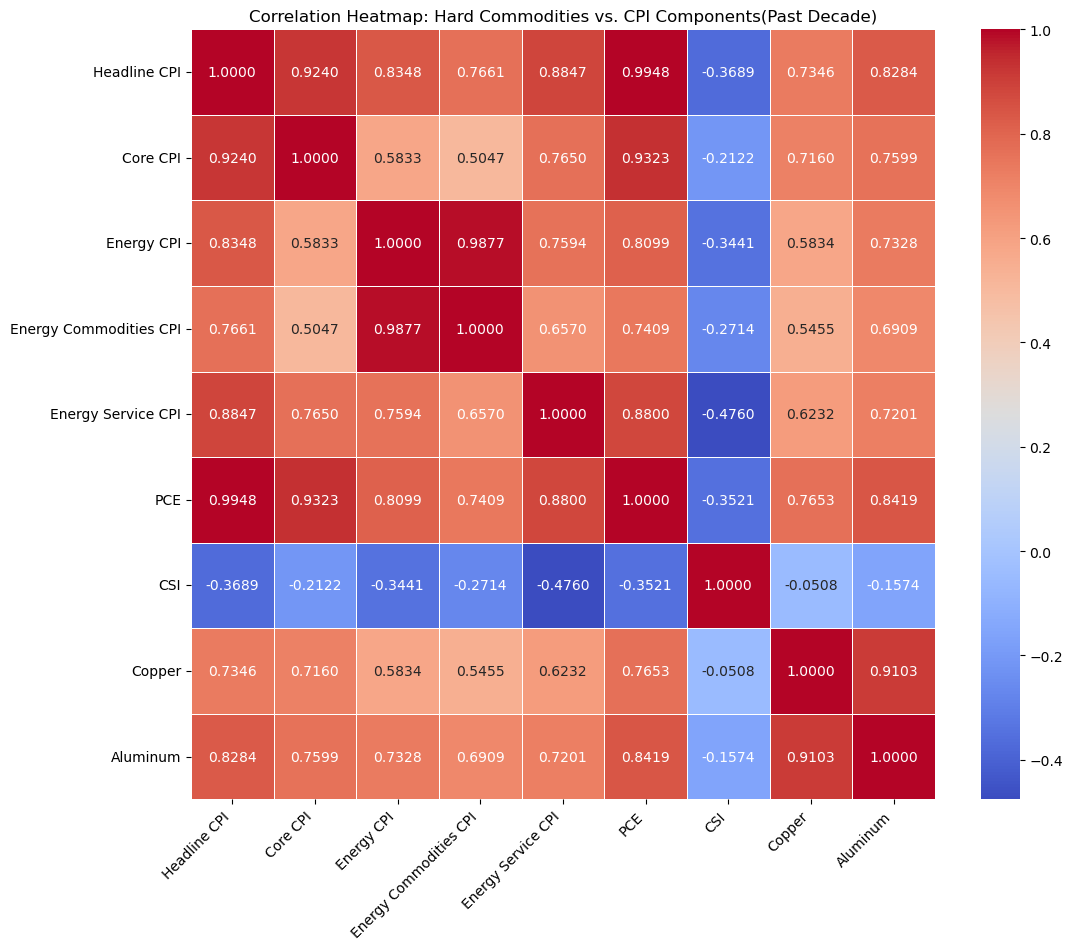

In [40]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix_10yrs, annot=True, fmt=".4f", cmap='coolwarm', linewidths=0.5)

tick_labels = ["Headline CPI","Core CPI","Energy CPI", "Energy Commodities CPI", "Energy Service CPI", 
               "PCE","CSI","Copper","Aluminum"]
heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities vs. CPI Components(Past Decade)')

plt.savefig('outputs/heatmap_CPI_10yrs.png')

plt.show()

In [41]:
# Correlation difference: Past Decade
corr_cop_energy_comm = corr_matrix_10yrs.loc['CPI_Energy_Commo','copper_value']
corr_cop_energy_ser = corr_matrix_10yrs.loc['CPI_Energy_Ser','copper_value']

corr_alu_energy_comm = corr_matrix_10yrs.loc['CPI_Energy_Commo','alu_value']
corr_alu_energy_ser = corr_matrix_10yrs.loc['CPI_Energy_Ser','alu_value']


corr_diff_cop = corr_cop_energy_ser - corr_cop_energy_comm
corr_diff_alu = corr_alu_energy_ser - corr_alu_energy_comm


print(f"Copper: Correlation difference between Energy Commodities CPI and Energy Service CPI is {corr_diff_cop:.3f}")
print(f"Aluminum: Correlation difference between Energy Commodities CPI and Energy Service CPI is {corr_diff_alu:.3f}")


Copper: Correlation difference between Energy Commodities CPI and Energy Service CPI is 0.078
Aluminum: Correlation difference between Energy Commodities CPI and Energy Service CPI is 0.029


In [42]:
def corr_statsig(correlations, n, alpha=0.05):


    for key, r in correlations.items():

        t_stat = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
        df = n - 2
        p_value = 2 * stats.t.sf(np.abs(t_stat), df)
        
        is_significant = p_value < alpha
        

        print(f"{key}:")
        print(f"  Correlation (r): {r:.4f}")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant: {'Yes' if is_significant else 'No'}")
        print("-" * 50)

In [43]:
# The lowest: Copper v.s. CPI Energy Commodities
correlations = {'Copper v.s. CPI(Energy Commodities)': 0.545460}

n = len(cpi_cop_alu_df)

corr_statsig(correlations, n)

Copper v.s. CPI(Energy Commodities):
  Correlation (r): 0.5455
  t-statistic: 7.0994
  p-value: 0.0000
  Significant: Yes
--------------------------------------------------


In [44]:
cpi_cop_alu_df.loc[cpi_cop_alu_df['copper_value'].idxmax()]

Date                    2022-03-01 00:00:00
CPI_all_items                       8.54743
CPI_excl_food_energy                6.47607
CPI_Energy                         31.77246
CPI_Energy_Commo                    47.8466
CPI_Energy_Ser                     13.37981
PCE                                 6.96708
CSI                               -30.03534
copper_value                   10230.893913
alu_value                       3498.373043
Name: 88, dtype: object

In [45]:
cpi_cop_alu_df.loc[cpi_cop_alu_df['alu_value'].idxmax()]

Date                    2022-03-01 00:00:00
CPI_all_items                       8.54743
CPI_excl_food_energy                6.47607
CPI_Energy                         31.77246
CPI_Energy_Commo                    47.8466
CPI_Energy_Ser                     13.37981
PCE                                 6.96708
CSI                               -30.03534
copper_value                   10230.893913
alu_value                       3498.373043
Name: 88, dtype: object

## 3.2 COVID-19 Period: March 2020 – May 2023
--- 
- hypothesis test (Pearson correlation)
- correlation differences

In [46]:
# "Covid Period" (according to WHO)
cpi_cop_alu_covid = cpi_cop_alu_df[(cpi_cop_alu_df['Date'] >= '2020-03-01')&
                                  (cpi_cop_alu_df['Date'] <= '2023-05-01')].reset_index(drop=True)

corr_matrix_covid = cpi_cop_alu_covid.drop(columns=['Date']).corr()
corr_matrix_covid

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              1.000000              0.956405    0.848461   
CPI_excl_food_energy       0.956405              1.000000    0.677621   
CPI_Energy                 0.848461              0.677621    1.000000   
CPI_Energy_Commo           0.767435              0.586824    0.986478   
CPI_Energy_Ser             0.939450              0.884633    0.750679   
PCE                        0.996820              0.959655    0.841403   
CSI                       -0.066666              0.012038    0.006711   
copper_value               0.698221              0.625958    0.780440   
alu_value                  0.832711              0.769189    0.822470   

                      CPI_Energy_Commo  CPI_Energy_Ser       PCE       CSI  \
CPI_all_items                 0.767435        0.939450  0.996820 -0.066666   
CPI_excl_food_energy          0.586824        0.884633  0.959655  0.012038   
CPI_Energy                    0.986478        0.750679  0.841403  0.006711   
CPI_Energy_Commo              1.000000        0.637275  0.762570  0.087315   
CPI_Energy_Ser                0.637275        1.000000  0.931466 -0.185473   
PCE                           0.762570        0.931466  1.000000 -0.032694   
CSI                           0.087315       -0.185473 -0.032694  1.000000   
copper_value                  0.793251        0.539179  0.726751  0.331640   
alu_value                     0.797196        0.677815  0.844598  0.037906   

                      copper_value  alu_value  
CPI_all_items             0.698221   0.832711  
CPI_excl_food_energy      0.625958   0.769189  
CPI_Energy                0.780440   0.822470  
CPI_Energy_Commo          0.793251   0.797196  
CPI_Energy_Ser            0.539179   0.677815  
PCE                       0.726751   0.844598  
CSI                       0.331640   0.037906  
copper_value              1.000000   0.895728  
alu_value                 0.895728   1.000000

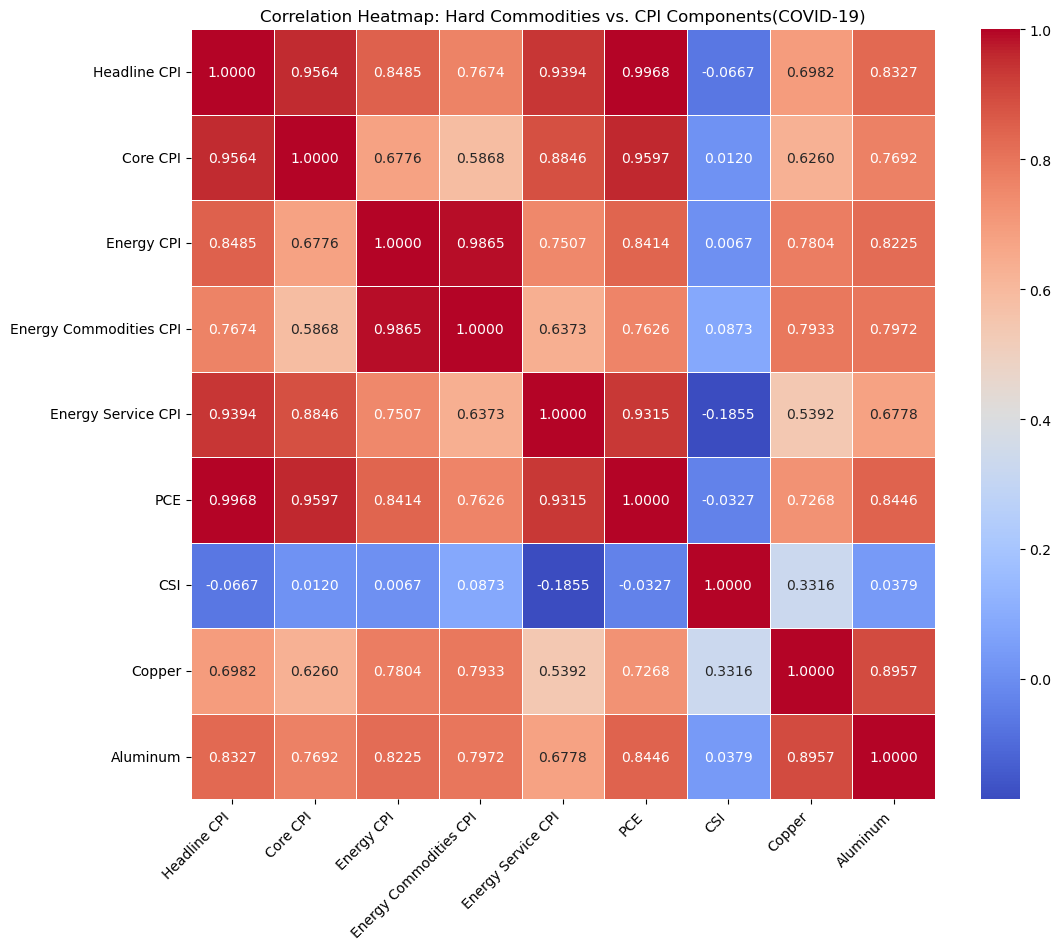

In [47]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix_covid, annot=True,fmt=".4f", cmap='coolwarm', linewidths=0.5)

tick_labels = ["Headline CPI","Core CPI","Energy CPI", "Energy Commodities CPI", "Energy Service CPI", 
               "PCE","CSI","Copper","Aluminum"]
heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities vs. CPI Components(COVID-19)')

plt.savefig('outputs/heatmap_CPI_covid.png')

plt.show()

In [48]:
# Correlation difference: "Covid Period"

corr_cop_energy_comm = corr_matrix_covid.loc['CPI_Energy_Commo','copper_value']
corr_cop_energy_ser = corr_matrix_covid.loc['CPI_Energy_Ser','copper_value']

corr_alu_energy_comm = corr_matrix_covid.loc['CPI_Energy_Commo','alu_value']
corr_alu_energy_ser = corr_matrix_covid.loc['CPI_Energy_Ser','alu_value']


corr_diff_cop = corr_cop_energy_ser - corr_cop_energy_comm
corr_diff_alu = corr_alu_energy_ser - corr_alu_energy_comm


print(f"Copper: Correlation difference between Energy Commodities CPI and Energy Service CPI is {corr_diff_cop:.3f}")
print(f"Aluminum: Correlation difference between Energy Commodities CPI and Energy Service CPI is {corr_diff_alu:.3f}")


Copper: Correlation difference between Energy Commodities CPI and Energy Service CPI is -0.254
Aluminum: Correlation difference between Energy Commodities CPI and Energy Service CPI is -0.119


In [49]:
print(len(cpi_cop_alu_covid))

39


In [50]:
# The lowest: Copper v.s. CPI Energy Commodities
correlations = {'Copper v.s. CPI(Energy Commodities)': 0.539179}

n = len(cpi_cop_alu_covid)

corr_statsig(correlations, n)

Copper v.s. CPI(Energy Commodities):
  Correlation (r): 0.5392
  t-statistic: 3.8942
  p-value: 0.0004
  Significant: Yes
--------------------------------------------------


## 3.3 Post-COVID Period: June 2023 – November 2024
--- 
- hypothesis test (Spearman Rank Correlation)
- correlation differences

In [51]:
cpi_cop_alu_pcovid = cpi_cop_alu_df[(cpi_cop_alu_df['Date'] >= '2023-06-01')&
                                  (cpi_cop_alu_df['Date'] <= '2024-11-01')].reset_index(drop=True)
cpi_cop_alu_pcovid.head()

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0 2023-06-01        3.05326               4.85522   -16.67792   
1 2023-07-01        3.27178               4.70760   -12.47732   
2 2023-08-01        3.71872               4.41280    -3.78274   
3 2023-09-01        3.69406               4.14370    -0.61157   
4 2023-10-01        3.24579               4.02170    -4.43948   

   CPI_Energy_Commo  CPI_Energy_Ser      PCE       CSI  copper_value  \
0         -26.92468        -1.12299  3.26157  28.40000   8396.517727   
1         -20.57423        -1.16982  3.37385  38.83495   8476.679048   
2          -4.47492        -2.72513  3.38712  19.24399   8347.828261   
3           2.04875        -3.45737  3.41634  15.69966   8276.713810   
4          -6.14629        -2.20775  2.99429   6.51085   7941.355909   

     alu_value  
0  2184.753636  
1  2159.732381  
2  2135.581739  
3  2184.673810  
4  2194.390909

In [52]:
print(len(cpi_cop_alu_pcovid))

18


In [53]:
#Post Covid Period (Using Spearman)
corr_matrix_postCovid = cpi_cop_alu_pcovid.drop(columns=['Date']).corr(method='spearman')
corr_matrix_postCovid

CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
CPI_all_items              1.000000              0.661507    0.384933   
CPI_excl_food_energy       0.661507              1.000000   -0.356037   
CPI_Energy                 0.384933             -0.356037    1.000000   
CPI_Energy_Commo           0.558308             -0.143447    0.942208   
CPI_Energy_Ser            -0.461300             -0.812178    0.453044   
PCE                        0.845201              0.905057   -0.038184   
CSI                        0.541796              0.661507   -0.060888   
copper_value              -0.391125             -0.708978    0.393189   
alu_value                 -0.562436             -0.762642    0.289990   

                      CPI_Energy_Commo  CPI_Energy_Ser       PCE       CSI  \
CPI_all_items                 0.558308       -0.461300  0.845201  0.541796   
CPI_excl_food_energy         -0.143447       -0.812178  0.905057  0.661507   
CPI_Energy                    0.942208        0.453044 -0.038184 -0.060888   
CPI_Energy_Commo              1.000000        0.238390  0.176471 -0.042312   
CPI_Energy_Ser                0.238390        1.000000 -0.725490 -0.364293   
PCE                           0.176471       -0.725490  1.000000  0.626419   
CSI                          -0.042312       -0.364293  0.626419  1.000000   
copper_value                  0.172343        0.882353 -0.614035 -0.135191   
alu_value                     0.108359        0.801858 -0.739938 -0.320949   

                      copper_value  alu_value  
CPI_all_items            -0.391125  -0.562436  
CPI_excl_food_energy     -0.708978  -0.762642  
CPI_Energy                0.393189   0.289990  
CPI_Energy_Commo          0.172343   0.108359  
CPI_Energy_Ser            0.882353   0.801858  
PCE                      -0.614035  -0.739938  
CSI                      -0.135191  -0.320949  
copper_value              1.000000   0.777090  
alu_value                 0.777090   1.000000

In [54]:
def plot_comm_vs_cpi_spearman(comm_value, comm_label, cpi_value, cpi_label, title_period,cpi_cop_alu_pcovid):

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=cpi_cop_alu_pcovid[comm_value], 
        mode='markers', 
        name=comm_label
    ))

    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=cpi_cop_alu_pcovid[cpi_value], 
        mode='lines',
        name=cpi_label, 
        yaxis='y2'
    ))

    cpi_cop_alu_pcovid['date_num'] = cpi_cop_alu_pcovid['Date'].map(pd.Timestamp.toordinal)

    comm_trendline = add_trendline(cpi_cop_alu_pcovid['date_num'], cpi_cop_alu_pcovid[comm_value])
    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=comm_trendline, 
        mode='lines', 
        name=f'{comm_label} Trendline', 
        line=dict(dash='dash', color='blue')
    ))

    cpi_trendline = add_trendline(cpi_cop_alu_pcovid['date_num'], cpi_cop_alu_pcovid[cpi_value])
    fig.add_trace(go.Scatter(
        x=cpi_cop_alu_pcovid['Date'], 
        y=cpi_trendline, 
        mode='lines', 
        name=f'{cpi_label} Trendline', 
        line=dict(dash='dash', color='red'),
        yaxis='y2'
    ))

    fig.update_layout(
        title=f'{comm_label} with {cpi_label} ({title_period})',
        xaxis_title='Date',
        yaxis=dict(
            title=comm_label,
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue'),
        ),
        yaxis2=dict(
            title=cpi_label,
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right'
        ),
        legend=dict(x=1.1, y=1),template='plotly_white'
    )

    fig.show()

    
    spearman_corr, p_value = stats.spearmanr(cpi_cop_alu_pcovid[cpi_value], cpi_cop_alu_pcovid[comm_value])

    print(f"Quick Summary")
    print(f"--------------")
    print(f"The Spearman Rank Correlation between {comm_label} and {cpi_label} is: {round(spearman_corr, 3)}")

In [55]:
plot_comm_vs_cpi_spearman(
    comm_value='copper_value', 
    comm_label='Global Monthly Copper Price',
    cpi_value='CPI_all_items', 
    cpi_label='Headline CPI',
    title_period ='From 2023-Jun to 2024-Nov',
    cpi_cop_alu_pcovid=cpi_cop_alu_pcovid, 
)

Quick Summary
--------------
The Spearman Rank Correlation between Global Monthly Copper Price and Headline CPI is: -0.391


In [56]:
def corr_statsig_spearman(x, y, alpha=0.05, label=""):
    
    spearman_corr, p_value = stats.spearmanr(x, y)
    
    is_significant = p_value < alpha
    
    print(f"{label}:")
    print(f"  Correlation (r): {spearman_corr:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'Yes' if is_significant else 'No'}\n")
    
    return spearman_corr, p_value, is_significant

In [57]:
# Spearman Rank Correlation (Copper v.s. Aluminum)
corr_statsig_spearman(cpi_cop_alu_pcovid['copper_value'],
                      cpi_cop_alu_pcovid['alu_value'],
                      label="Testing: Copper v.s. Aluminum")

Testing: Copper v.s. Aluminum:
  Correlation (r): 0.7771
  P-value: 0.0001
  Significant: Yes



(0.7770897832817338, 0.00014812554588688426, True)

In [58]:
# Copper v.s. CPI
cpi_pce_columns = [
    'CPI_all_items', 'CPI_excl_food_energy', 'CPI_Energy', 
    'CPI_Energy_Commo', 'CPI_Energy_Ser', 'PCE'
]


for col in cpi_pce_columns:
    label = f"Copper v.s. {col}"
    print(f"\nTesting: {label}")
    corr_statsig_spearman(cpi_cop_alu_pcovid[col], cpi_cop_alu_pcovid['copper_value'],label=label)
    print("-" * 50)


Testing: Copper v.s. CPI_all_items
Copper v.s. CPI_all_items:
  Correlation (r): -0.3911
  P-value: 0.1085
  Significant: No

--------------------------------------------------

Testing: Copper v.s. CPI_excl_food_energy
Copper v.s. CPI_excl_food_energy:
  Correlation (r): -0.7090
  P-value: 0.0010
  Significant: Yes

--------------------------------------------------

Testing: Copper v.s. CPI_Energy
Copper v.s. CPI_Energy:
  Correlation (r): 0.3932
  P-value: 0.1065
  Significant: No

--------------------------------------------------

Testing: Copper v.s. CPI_Energy_Commo
Copper v.s. CPI_Energy_Commo:
  Correlation (r): 0.1723
  P-value: 0.4941
  Significant: No

--------------------------------------------------

Testing: Copper v.s. CPI_Energy_Ser
Copper v.s. CPI_Energy_Ser:
  Correlation (r): 0.8824
  P-value: 0.0000
  Significant: Yes

--------------------------------------------------

Testing: Copper v.s. PCE
Copper v.s. PCE:
  Correlation (r): -0.6140
  P-value: 0.0067
  Signi

In [59]:
# Aluminum v.s. CPI
for col in cpi_pce_columns:
    label = f"Aluminum v.s. {col}"
    print(f"\nTesting: {label}")
    corr_statsig_spearman(cpi_cop_alu_pcovid[col], cpi_cop_alu_pcovid['alu_value'], label=label)
    print("-" * 50)


Testing: Aluminum v.s. CPI_all_items
Aluminum v.s. CPI_all_items:
  Correlation (r): -0.5624
  P-value: 0.0151
  Significant: Yes

--------------------------------------------------

Testing: Aluminum v.s. CPI_excl_food_energy
Aluminum v.s. CPI_excl_food_energy:
  Correlation (r): -0.7626
  P-value: 0.0002
  Significant: Yes

--------------------------------------------------

Testing: Aluminum v.s. CPI_Energy
Aluminum v.s. CPI_Energy:
  Correlation (r): 0.2900
  P-value: 0.2431
  Significant: No

--------------------------------------------------

Testing: Aluminum v.s. CPI_Energy_Commo
Aluminum v.s. CPI_Energy_Commo:
  Correlation (r): 0.1084
  P-value: 0.6687
  Significant: No

--------------------------------------------------

Testing: Aluminum v.s. CPI_Energy_Ser
Aluminum v.s. CPI_Energy_Ser:
  Correlation (r): 0.8019
  P-value: 0.0001
  Significant: Yes

--------------------------------------------------

Testing: Aluminum v.s. PCE
Aluminum v.s. PCE:
  Correlation (r): -0.7399


# 4. Cryptocurrencies
---
- **4.1 Interconnections among Cyrptocurrencies (Bitcoin/Ether)**
- **4.2 Cryptocurrencies and Hard Commodities (Copper/Aluminum)**
    - Includes additional analysis on **gold**.

## 4.1 Interconnections among Cyrptocurrencies
---
- **4.1.1 Overview**
- **4.1.2 Spot Market Analysis**
- **4.1.3 Spot v.s. Futures Market Dynamics**

In [60]:
bitcoin = pd.read_csv("resources/bitcoin_daily.csv")
bitcoin_f = pd.read_csv("resources/bitcoin_daily_f.csv")
eth = pd.read_csv("resources/eth_daily.csv")
eth_f = pd.read_csv("resources/eth_daily_f.csv")

In [61]:
bitcoin_df = bitcoin[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_b', 'Volume': 'volume_b'})
bitcoin_f_df = bitcoin_f[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_b_f', 'Volume': 'volume_b_f'})
eth_df = eth[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_eth', 'Volume': 'volume_eth'})
eth_f_df= eth_f[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_eth_f','Volume': 'volume_eth_f'})                    

In [62]:
for df in [bitcoin_df, bitcoin_f_df, eth_df, eth_f_df]:
    df['Date'] = pd.to_datetime(df['Date'])

In [63]:
crypto_dataframes = {
    'bitcoin': bitcoin_df,
    'bitcoin_f': bitcoin_f_df,
    'eth': eth_df,
    'eth_f': eth_f_df,
}

crypto_full = crypto_dataframes['bitcoin']
for key in list(crypto_dataframes.keys())[1:]:
    crypto_full = crypto_full.merge(crypto_dataframes[key], on='Date', how='outer')

crypto_full = crypto_full.sort_values(by='Date').reset_index(drop=True)

crypto_full.head()

Date     close_b  volume_b  close_b_f  volume_b_f  close_eth  \
0 2014-11-01  325.748993  16677200        NaN         NaN        NaN   
1 2014-11-02  325.891998   8603620        NaN         NaN        NaN   
2 2014-11-03  327.553986  12948500        NaN         NaN        NaN   
3 2014-11-04  330.492004  15655500        NaN         NaN        NaN   
4 2014-11-05  339.485992  19817200        NaN         NaN        NaN   

   volume_eth  close_eth_f  volume_eth_f  
0         NaN          NaN           NaN  
1         NaN          NaN           NaN  
2         NaN          NaN           NaN  
3         NaN          NaN           NaN  
4         NaN          NaN           NaN

### 4.1.1 Overview

In [64]:
# Correlation table: ignoring NA values
corr_crypto_full= crypto_full.drop(columns=['Date']).corr()
corr_crypto_full

close_b  volume_b  close_b_f  volume_b_f  close_eth  \
close_b       1.000000  0.652494   0.999759    0.369283   0.912012   
volume_b      0.652494  1.000000   0.518842    0.553870   0.351302   
close_b_f     0.999759  0.518842   1.000000    0.369564   0.910628   
volume_b_f    0.369283  0.553870   0.369564    1.000000   0.283166   
close_eth     0.912012  0.351302   0.910628    0.283166   1.000000   
volume_eth    0.547714  0.868551   0.578504    0.495602   0.476170   
close_eth_f   0.771006  0.189968   0.772002   -0.069005   0.998875   
volume_eth_f -0.107059  0.214849  -0.106445    0.664195  -0.057463   

              volume_eth  close_eth_f  volume_eth_f  
close_b         0.547714     0.771006     -0.107059  
volume_b        0.868551     0.189968      0.214849  
close_b_f       0.578504     0.772002     -0.106445  
volume_b_f      0.495602    -0.069005      0.664195  
close_eth       0.476170     0.998875     -0.057463  
volume_eth      1.000000     0.360287      0.268046  
close_eth_f     0.360287     1.000000     -0.057367  
volume_eth_f    0.268046    -0.057367      1.000000

In [65]:
# Correlation table: excluding NA values
# Note 1: overall correlation decrease except ETH futures and its volume.
# Note 2: ETH futures data is only available starting February 2021.
corr_crypto_full_na = crypto_full.drop(columns=['Date']).dropna().corr()
corr_crypto_full_na

close_b  volume_b  close_b_f  volume_b_f  close_eth  \
close_b       1.000000  0.388480   0.999443    0.120199   0.771179   
volume_b      0.388480  1.000000   0.389403    0.439476   0.186309   
close_b_f     0.999443  0.389403   1.000000    0.120380   0.770919   
volume_b_f    0.120199  0.439476   0.120380    1.000000  -0.069998   
close_eth     0.771179  0.186309   0.770919   -0.069998   1.000000   
volume_eth    0.418609  0.771962   0.419182    0.320378   0.357557   
close_eth_f   0.771006  0.189968   0.772002   -0.069005   0.998875   
volume_eth_f -0.107059  0.214849  -0.106445    0.664195  -0.057463   

              volume_eth  close_eth_f  volume_eth_f  
close_b         0.418609     0.771006     -0.107059  
volume_b        0.771962     0.189968      0.214849  
close_b_f       0.419182     0.772002     -0.106445  
volume_b_f      0.320378    -0.069005      0.664195  
close_eth       0.357557     0.998875     -0.057463  
volume_eth      1.000000     0.360287      0.268046  
close_eth_f     0.360287     1.000000     -0.057367  
volume_eth_f    0.268046    -0.057367      1.000000

### 4.1.2 Spot Market Analysis
---
- **Period 1**: Seven-year (Nov 9, 2017 – Nov 29, 2024)
- **Period 2**: Five-year (Nov 2019 – Nov 2024)

In [66]:
# Cryptocurrency (Spot Market)
# Date Range: Nov 9, 2017 – Nov 29, 2024 (approx. 7 years)
# Ether Data Availability: Nov 9, 2017
crypto_spot_df = pd.merge(bitcoin_df,eth_df, on='Date', how='right').rename(columns = {"Date":"date"})
crypto_spot_df.head()

date      close_b    volume_b   close_eth  volume_eth
0 2017-11-09  7143.580078  3226249984  320.884003   893249984
1 2017-11-10  6618.140137  5208249856  299.252991   885985984
2 2017-11-11  6357.600098  4908680192  314.681000   842300992
3 2017-11-12  5950.069824  8957349888  307.907990  1613479936
4 2017-11-13  6559.490234  6263249920  316.716003  1041889984

In [67]:
# Cryptocurrency (Spot Market) - Correlation table
# Date Range: Nov 9, 2017 – Nov 29, 2024 (approx. 7 years)
crypto_spot_df.drop(columns=['date']).corr()

close_b  volume_b  close_eth  volume_eth
close_b     1.000000  0.476494   0.912012    0.547714
volume_b    0.476494  1.000000   0.351302    0.868551
close_eth   0.912012  0.351302   1.000000    0.476170
volume_eth  0.547714  0.868551   0.476170    1.000000

In [68]:
# Cryptocurrency (Spot Market) - Correlation table
# Date Range: Nov 2019 – Nov 2024 (5 years)
crypto_spot_5yr_df = crypto_spot_df[(crypto_spot_df['date'] >= '2019-11-01')&
                                  (crypto_spot_df['date'] <= '2024-11-29')].reset_index(drop=True)
corr_crypto_spot_5yr = crypto_spot_5yr_df.drop(columns=['date']).corr()
corr_crypto_spot_5yr

close_b  volume_b  close_eth  volume_eth
close_b     1.000000  0.255238   0.873776    0.355863
volume_b    0.255238  1.000000   0.088867    0.815500
close_eth   0.873776  0.088867   1.000000    0.265302
volume_eth  0.355863  0.815500   0.265302    1.000000

### 4.1.3 Spot v.s. Futures Market Dynamics
---
- Heatmap Visualization: Correlation v.s. Percentage Change 
    - **Period 1**: Three-year analysis (Nov 2021 to Nov 2024)
    - **Period 2**: Two-year analysis  (Nov 2022 to Nov 2024)
    - **Period 3**: One-year analysis (Nov 2023 to Nov 2024)

In [69]:
# Cryptocurrency (Futures Market)
# Date Range: Feb 05,2021 ~ Nov 29, 2024 (> 3 yrs)
crypto_f_df = pd.merge(bitcoin_f_df,eth_f_df, on='Date', how='right').rename(columns = {"Date":"date"})
crypto_f_df.tail()

date     close_b_f  volume_b_f  close_eth_f  volume_eth_f
957 2024-11-22  99485.000000       17264  3306.500000          9034
958 2024-11-25  94945.000000       18093  3511.500000         14501
959 2024-11-26  90995.000000       15780  3327.000000         10458
960 2024-11-27  96785.000000       10755  3641.000000          9680
961 2024-11-29  98339.757812        9278  3629.689941          5566

#### Period 1: Three-year analysis (Nov 2021 to Nov 2024)

In [70]:
# Cryptocurrency (Futures Market)
# Date Range: Nov 2021 ~ Nov 2024 (3 yrs)
crypto_f_3yr_df = crypto_f_df[(crypto_f_df['date'] >= '2021-11-01')&
                                  (crypto_f_df['date'] <= '2024-11-29')].reset_index(drop=True)

In [71]:
# Cryptocurrency (Spot & Futures)
# Date Range: Nov 2021 ~ Nov 2024 (3 yrs)
crypto_spot_3yr_df = crypto_spot_df[(crypto_spot_df['date'] >= '2021-11-01')&
                                  (crypto_spot_df['date'] <= '2024-11-29')].reset_index(drop=True)
crypto_3yrs_full = pd.merge(crypto_spot_3yr_df,crypto_f_3yr_df, on='date', how='left')
crypto_3yrs_full.head()

date       close_b     volume_b    close_eth   volume_eth  close_b_f  \
0 2021-11-01  61004.406250  36150572843  4324.626953  17985288261    61615.0   
1 2021-11-02  63226.402344  37746665647  4584.798828  20794448222    64015.0   
2 2021-11-03  62970.046875  36124731509  4607.193848  21220463155    63065.0   
3 2021-11-04  61452.230469  32615846901  4537.324219  18415244464    61360.0   
4 2021-11-05  61125.675781  30605102446  4486.243164  15086003586    61380.0   

   volume_b_f  close_eth_f  volume_eth_f  
0      4979.0      4378.75        3798.0  
1      5238.0      4550.75        5846.0  
2      5495.0      4668.50        2840.0  
3      5009.0      4515.50        4404.0  
4      3534.0      4530.25        1912.0

In [72]:
# Cryptocurrency (Spot & Futures)-Correlation table
# Date Range: Nov 2021 ~ Nov 2024 (3 yrs)
corr_crypto_3yrs_full = crypto_3yrs_full.drop(columns=['date']).corr()
corr_crypto_3yrs_full

close_b  volume_b  close_eth  volume_eth  close_b_f  \
close_b       1.000000  0.383465   0.830366    0.462236   0.999646   
volume_b      0.383465  1.000000   0.279731    0.884331   0.444633   
close_eth     0.830366  0.279731   1.000000    0.416342   0.827729   
volume_eth    0.462236  0.884331   0.416342    1.000000   0.494853   
close_b_f     0.999646  0.444633   0.827729    0.494853   1.000000   
volume_b_f    0.154174  0.623457  -0.043369    0.495696   0.153402   
close_eth_f   0.828375  0.305681   0.999214    0.439630   0.828622   
volume_eth_f -0.059949  0.545139  -0.134524    0.575040  -0.060864   

              volume_b_f  close_eth_f  volume_eth_f  
close_b         0.154174     0.828375     -0.059949  
volume_b        0.623457     0.305681      0.545139  
close_eth      -0.043369     0.999214     -0.134524  
volume_eth      0.495696     0.439630      0.575040  
close_b_f       0.153402     0.828622     -0.060864  
volume_b_f      1.000000    -0.043770      0.706953  
close_eth_f    -0.043770     1.000000     -0.136080  
volume_eth_f    0.706953    -0.136080      1.000000

In [73]:
corr_crypto_3yrs_full.to_csv("outputs/corr_fullCrypto_3yr.csv", index=True)

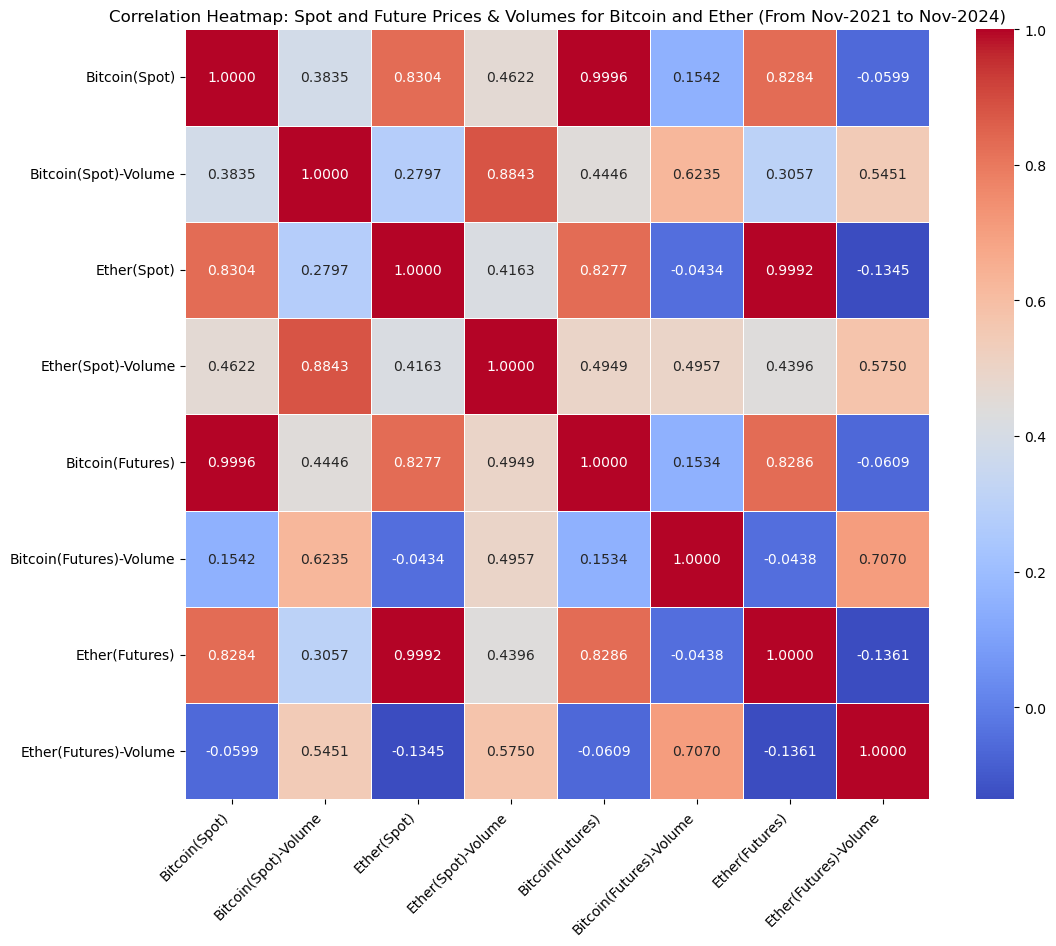

In [74]:
# Cryptocurrency (Spot & Futures)-Correlation Heatmap
# Date Range: Nov 2021 ~ Nov 2024 (3 yrs)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_crypto_3yrs_full, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Volume", "Ether(Futures)", "Ether(Futures)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Spot and Future Prices & Volumes for Bitcoin and Ether (From Nov-2021 to Nov-2024)')

plt.savefig('outputs/heatmap_crypto_spotFutures_3yrs.png', dpi=300)

plt.show()

In [75]:
def compare_correlation(short_df, long_df):

    # Ensure the dataframes have the same shape
    if short_df.shape != long_df.shape:
        raise ValueError("The correlation dataframes must have the same shape")
    
    # Calculate the correlation difference
    correlation_diff = short_df - long_df

    # Map differences to 'High', 'Low', 'Same'
    comparison_matrix = correlation_diff.applymap(
        lambda x: 'High' if x > 0 else 'Low' if x < 0 else 'Same'
    )

    # Ensure diagonal is labeled 'Same' (self-correlation is always the same)
    for i in comparison_matrix.index:
        comparison_matrix.loc[i, i] = 'Same'
    
    return comparison_matrix

In [76]:
def correlation_change(short_df, long_df):
    # Ensure the dataframes have the same shape
    if short_df.shape != long_df.shape:
        raise ValueError("The correlation dataframes must have the same shape")
    
    # Calculate the percentage change
    percentage_change = ((short_df - long_df) / long_df.abs()) * 100
    
    # Ensure diagonal is labeled as 0 (no meaningful change in self-correlation)
    for i in percentage_change.index:
        percentage_change.loc[i, i] = 0.0
    
    return percentage_change

In [77]:
# Calculate the correlation difference
# dataframe 1 = corr_crypto_3yr_full: Nov 2021 ~ Nov 2024
# dataframe 2 = corr_crypto_full_na: Feb 2021 ~ Nov 2024
comparison_matrix_crypto3Yrs = compare_correlation(corr_crypto_3yrs_full, corr_crypto_full_na)
comparison_matrix_crypto3Yrs

close_b close_b_f close_eth close_eth_f volume_b volume_b_f  \
close_b         Same      High      High        High      Low       High   
close_b_f       High      Same      High        High     High       High   
close_eth       High      High      Same        High     High       High   
close_eth_f     High      High      High        Same     High       High   
volume_b         Low      High      High        High     Same       High   
volume_b_f      High      High      High        High     High       Same   
volume_eth      High      High      High        High     High       High   
volume_eth_f    High      High       Low         Low     High       High   

             volume_eth volume_eth_f  
close_b            High         High  
close_b_f          High         High  
close_eth          High          Low  
close_eth_f        High          Low  
volume_b           High         High  
volume_b_f         High         High  
volume_eth         Same         High  
volume_eth_f       High         Same

In [78]:
comparison_matrix_crypto3Yrs.to_csv("outputs/matrix_crypto_3yrVSfullna.csv", index=True)

In [79]:
# Percentage Change in Correlation (Nov 2021 - Nov 2024 vs. Feb 2021 - Nov 2024)
percent_change_fullCrypto_3yr = correlation_change(corr_crypto_3yrs_full, corr_crypto_full_na)
percent_change_fullCrypto_3yr

close_b  close_b_f   close_eth  close_eth_f    volume_b  \
close_b        0.000000   0.020308    7.674821     7.440804   -1.290905   
close_b_f      0.020308   0.000000    7.369220     7.334157   14.183264   
close_eth      7.674821   7.369220    0.000000     0.033908   50.143331   
close_eth_f    7.440804   7.334157    0.033908     0.000000   60.911309   
volume_b      -1.290905  14.183264   50.143331    60.911309    0.000000   
volume_b_f    28.265501  27.430749   38.042037    36.570374   41.863795   
volume_eth    10.422096  18.052205   16.440758    22.022098   14.556313   
volume_eth_f  44.003628  42.821261 -134.106640  -137.211203  153.730615   

              volume_b_f  volume_eth  volume_eth_f  
close_b        28.265501   10.422096     44.003628  
close_b_f      27.430749   18.052205     42.821261  
close_eth      38.042037   16.440758   -134.106640  
close_eth_f    36.570374   22.022098   -137.211203  
volume_b       41.863795   14.556313    153.730615  
volume_b_f      0.000000   54.722498      6.437575  
volume_eth     54.722498    0.000000    114.530628  
volume_eth_f    6.437575  114.530628      0.000000

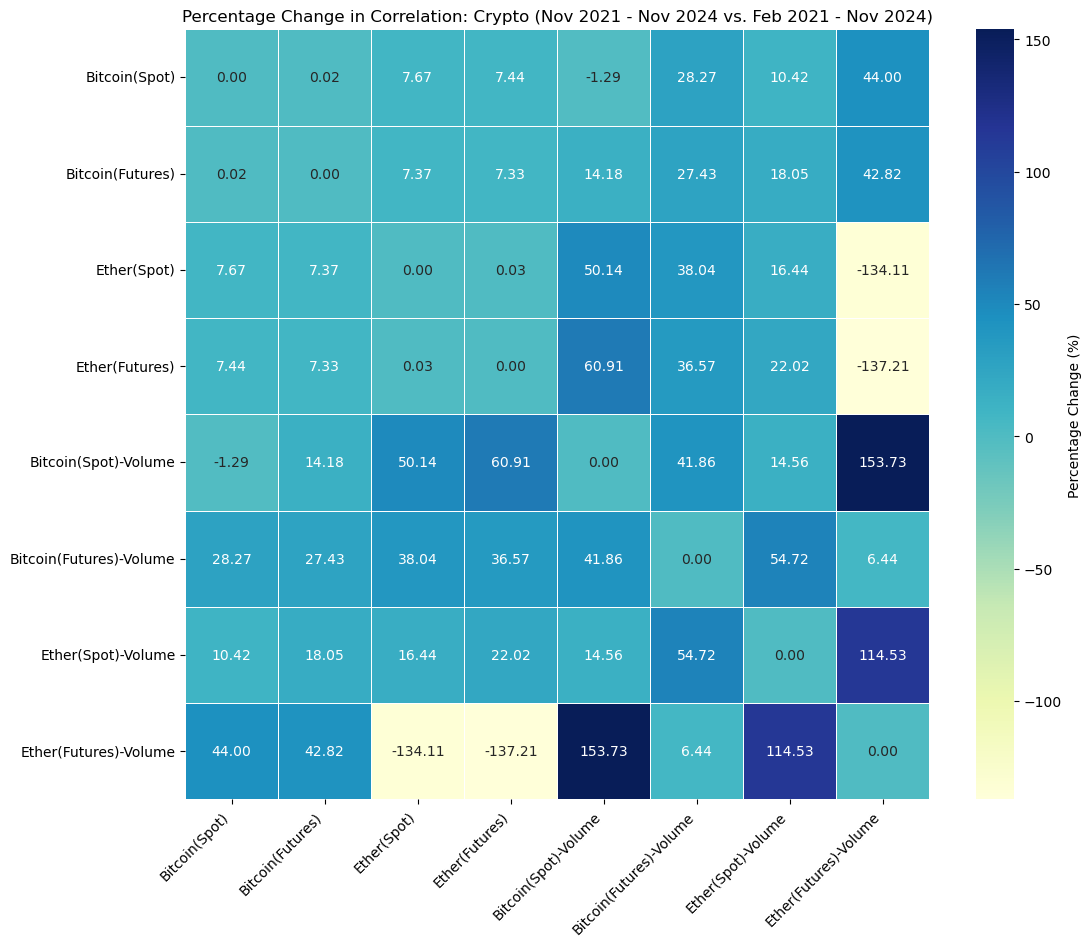

In [80]:
# Percentage Change in Correlation (Nov 2021 - Nov 2024 vs. Feb 2021 - Nov 2024)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_fullCrypto_3yr, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

tick_labels = ["Bitcoin(Spot)","Bitcoin(Futures)","Ether(Spot)","Ether(Futures)",
               "Bitcoin(Spot)-Volume","Bitcoin(Futures)-Volume","Ether(Spot)-Volume","Ether(Futures)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: Crypto (Nov 2021 - Nov 2024 vs. Feb 2021 - Nov 2024)')

plt.savefig('outputs/heatmap_changeinCorr_crypto_3yrs.png', dpi=300)

plt.show()

#### Period 2: Two-year analysis  (Nov 2022 to Nov 2024)

In [81]:
# Cryptocurrency (Spot & Futures)-Correlation Table
# Date Range: Nov 2022 ~ Nov 2024 (2 yrs)
corr_crypto_2yrs_full = crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2022-11-01')&
                        (crypto_3yrs_full['date'] <= '2024-11-29')].drop(columns=['date']).corr()
corr_crypto_2yrs_full

close_b  volume_b  close_eth  volume_eth  close_b_f  \
close_b       1.000000  0.508103   0.920906    0.665929   0.999678   
volume_b      0.508103  1.000000   0.412306    0.914197   0.569906   
close_eth     0.920906  0.412306   1.000000    0.582463   0.918288   
volume_eth    0.665929  0.914197   0.582463    1.000000   0.698127   
close_b_f     0.999678  0.569906   0.918288    0.698127   1.000000   
volume_b_f    0.262028  0.678981   0.214895    0.615482   0.260667   
close_eth_f   0.919563  0.463724   0.999148    0.615821   0.919307   
volume_eth_f  0.099766  0.605049   0.062152    0.590436   0.098394   

              volume_b_f  close_eth_f  volume_eth_f  
close_b         0.262028     0.919563      0.099766  
volume_b        0.678981     0.463724      0.605049  
close_eth       0.214895     0.999148      0.062152  
volume_eth      0.615482     0.615821      0.590436  
close_b_f       0.260667     0.919307      0.098394  
volume_b_f      1.000000     0.212302      0.763891  
close_eth_f     0.212302     1.000000      0.059034  
volume_eth_f    0.763891     0.059034      1.000000

In [82]:
corr_crypto_2yrs_full.to_csv("outputs/corr_fullCrypto_2yr.csv", index=True)

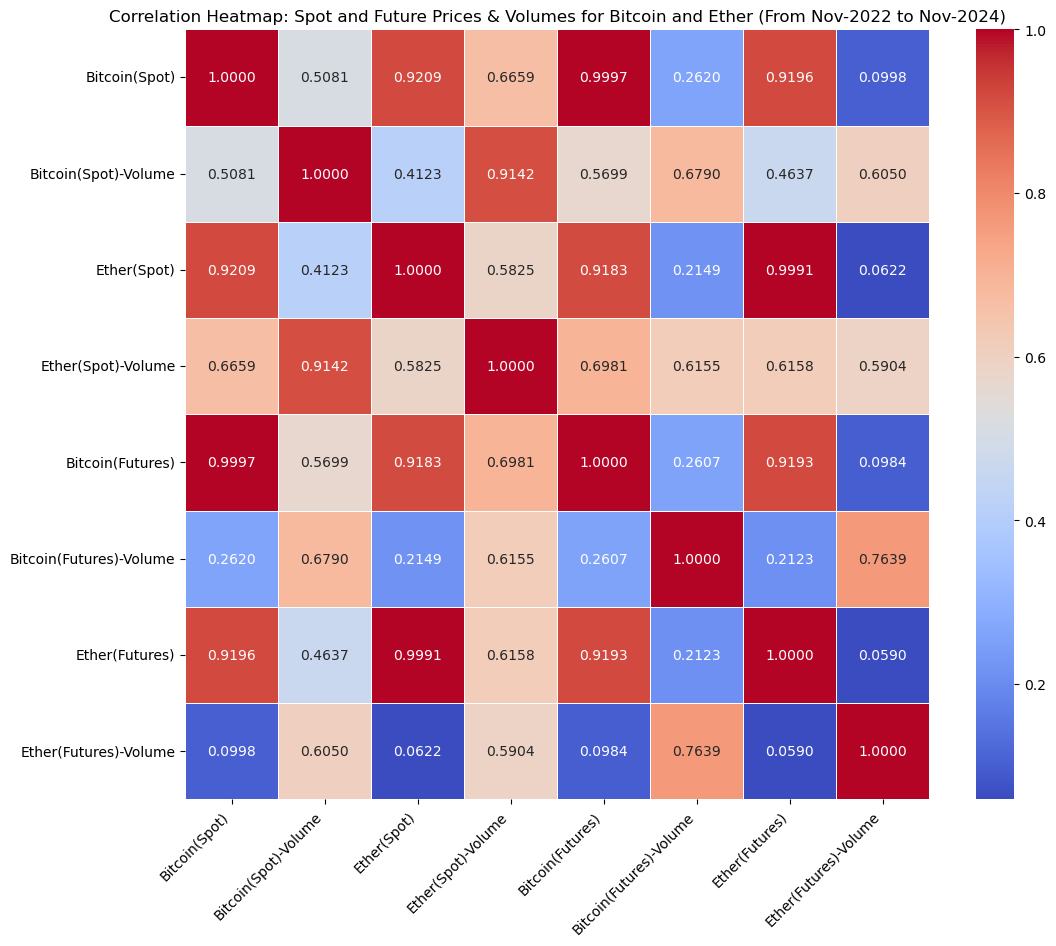

In [83]:
# Cryptocurrency (Spot & Futures) - Correlation Heatmap
# Date Range: Nov 2022 ~ Nov 2024 (2 yrs)

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_crypto_2yrs_full, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Volume", "Ether(Futures)", "Ether(Futures)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Spot and Future Prices & Volumes for Bitcoin and Ether (From Nov-2022 to Nov-2024)')

plt.savefig('outputs/heatmap_crypto_spotFutures_2yrs.png', dpi=300)

plt.show()

In [84]:
# Calculate the correlation difference
# dataframe 1 = corr_crypto_3yr_full: Nov 2021 ~ Nov 2024
# dataframe 2 = corr_crypto_2yrs_full: Nov 2022 ~ Nov 2024
comparison_matrix_crypto2Yrs = compare_correlation(corr_crypto_2yrs_full, corr_crypto_3yrs_full)
comparison_matrix_crypto2Yrs

close_b volume_b close_eth volume_eth close_b_f volume_b_f  \
close_b         Same     High      High       High      High       High   
volume_b        High     Same      High       High      High       High   
close_eth       High     High      Same       High      High       High   
volume_eth      High     High      High       Same      High       High   
close_b_f       High     High      High       High      Same       High   
volume_b_f      High     High      High       High      High       Same   
close_eth_f     High     High       Low       High      High       High   
volume_eth_f    High     High      High       High      High       High   

             close_eth_f volume_eth_f  
close_b             High         High  
volume_b            High         High  
close_eth            Low         High  
volume_eth          High         High  
close_b_f           High         High  
volume_b_f          High         High  
close_eth_f         Same         High  
volume_eth_f        High         Same

In [85]:
# Percentage Change in Correlation (Nov 2022 - Nov 2024 vs. Nov 2021 - Nov 2024)/ 2 yrs v.s. 3 yrs
percent_change_fullCrypto_2yr = correlation_change(corr_crypto_2yrs_full, corr_crypto_3yrs_full)
percent_change_fullCrypto_2yr

close_b   volume_b   close_eth  volume_eth   close_b_f  \
close_b         0.000000  32.503186   10.903610   44.066696    0.003141   
volume_b       32.503186   0.000000   47.393588    3.377143   28.174595   
close_eth      10.903610  47.393588    0.000000   39.900339   10.940576   
volume_eth     44.066696   3.377143   39.900339    0.000000   41.077533   
close_b_f       0.003141  28.174595   10.940576   41.077533    0.000000   
volume_b_f     69.955656   8.905767  595.500147   24.165208   69.924218   
close_eth_f    11.007983  51.701957   -0.006580   40.077121   10.944047   
volume_eth_f  266.417331  10.989893  146.201583    2.677356  261.662523   

              volume_b_f  close_eth_f  volume_eth_f  
close_b        69.955656    11.007983    266.417331  
volume_b        8.905767    51.701957     10.989893  
close_eth     595.500147    -0.006580    146.201583  
volume_eth     24.165208    40.077121      2.677356  
close_b_f      69.924218    10.944047    261.662523  
volume_b_f      0.000000   585.040929      8.054091  
close_eth_f   585.040929     0.000000    143.382030  
volume_eth_f    8.054091   143.382030      0.000000

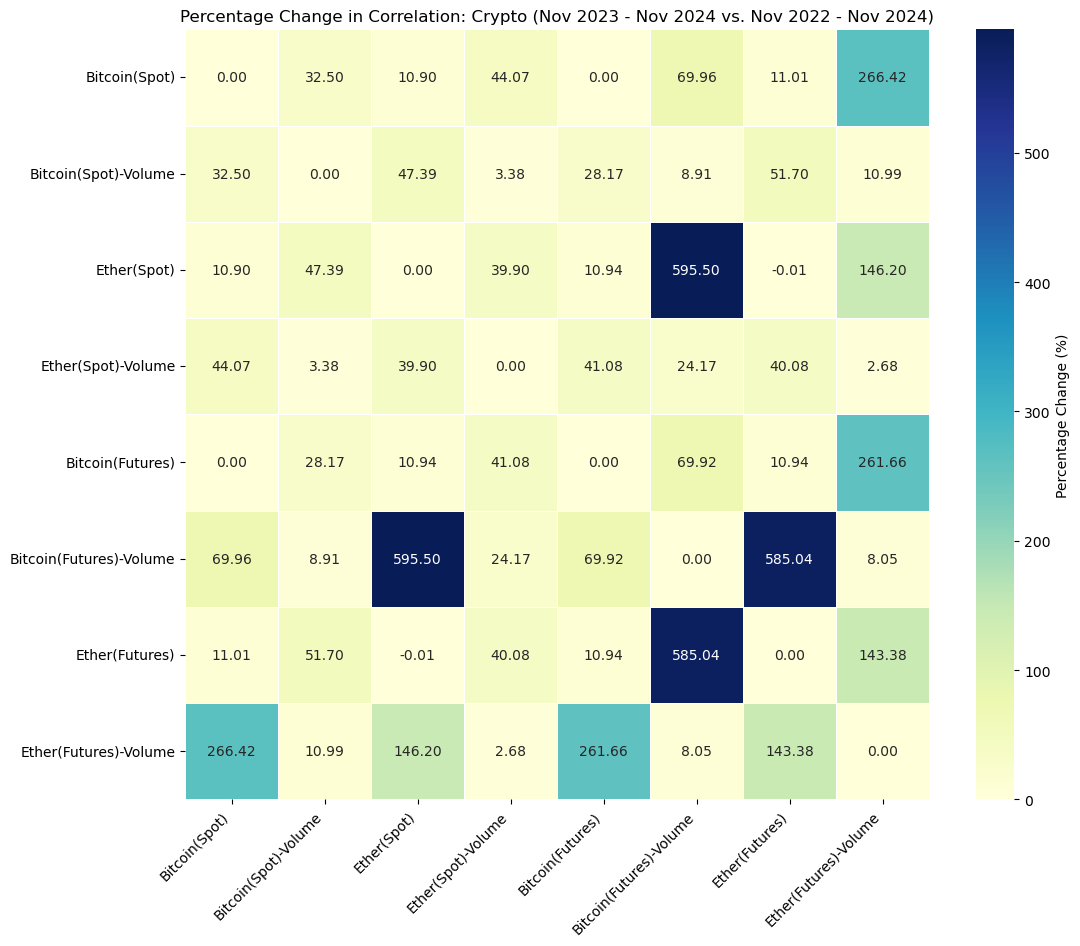

In [86]:
# Percentage Change in Correlation (Nov 2023 - Nov 2024 vs. Nov 2022 - Nov 2024)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_fullCrypto_2yr, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Volume", "Ether(Futures)", "Ether(Futures)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: Crypto (Nov 2023 - Nov 2024 vs. Nov 2022 - Nov 2024)')

plt.savefig('outputs/heatmap_changeinCorr_crypto_2yrs.png', dpi=300)

plt.show()

#### Period 3: One-year analysis (Nov 2023 to Nov 2024)

In [87]:
# Cryptocurrency (Spot & Futures)-Correlation Table
# Date Range: Nov 2023 ~ Nov 2024 (1 yr)
corr_crypto_1yr_full = crypto_3yrs_full[(crypto_3yrs_full['date'] >= '2023-11-01')&
                                  (crypto_3yrs_full['date'] <= '2024-11-29')].drop(columns=['date']).corr()
corr_crypto_1yr_full

close_b  volume_b  close_eth  volume_eth  close_b_f  \
close_b       1.000000  0.547229   0.722561    0.571499   0.998810   
volume_b      0.547229  1.000000   0.307027    0.918240   0.620779   
close_eth     0.722561  0.307027   1.000000    0.362963   0.716869   
volume_eth    0.571499  0.918240   0.362963    1.000000   0.598797   
close_b_f     0.998810  0.620779   0.716869    0.598797   1.000000   
volume_b_f    0.193066  0.702857   0.076886    0.653150   0.189633   
close_eth_f   0.721355  0.350606   0.997595    0.392456   0.719723   
volume_eth_f  0.096635  0.537747   0.000733    0.653845   0.093582   

              volume_b_f  close_eth_f  volume_eth_f  
close_b         0.193066     0.721355      0.096635  
volume_b        0.702857     0.350606      0.537747  
close_eth       0.076886     0.997595      0.000733  
volume_eth      0.653150     0.392456      0.653845  
close_b_f       0.189633     0.719723      0.093582  
volume_b_f      1.000000     0.070602      0.675467  
close_eth_f     0.070602     1.000000     -0.008393  
volume_eth_f    0.675467    -0.008393      1.000000

In [88]:
corr_crypto_1yr_full.to_csv("outputs/corr_fullCrypto_1yr.csv", index=True)

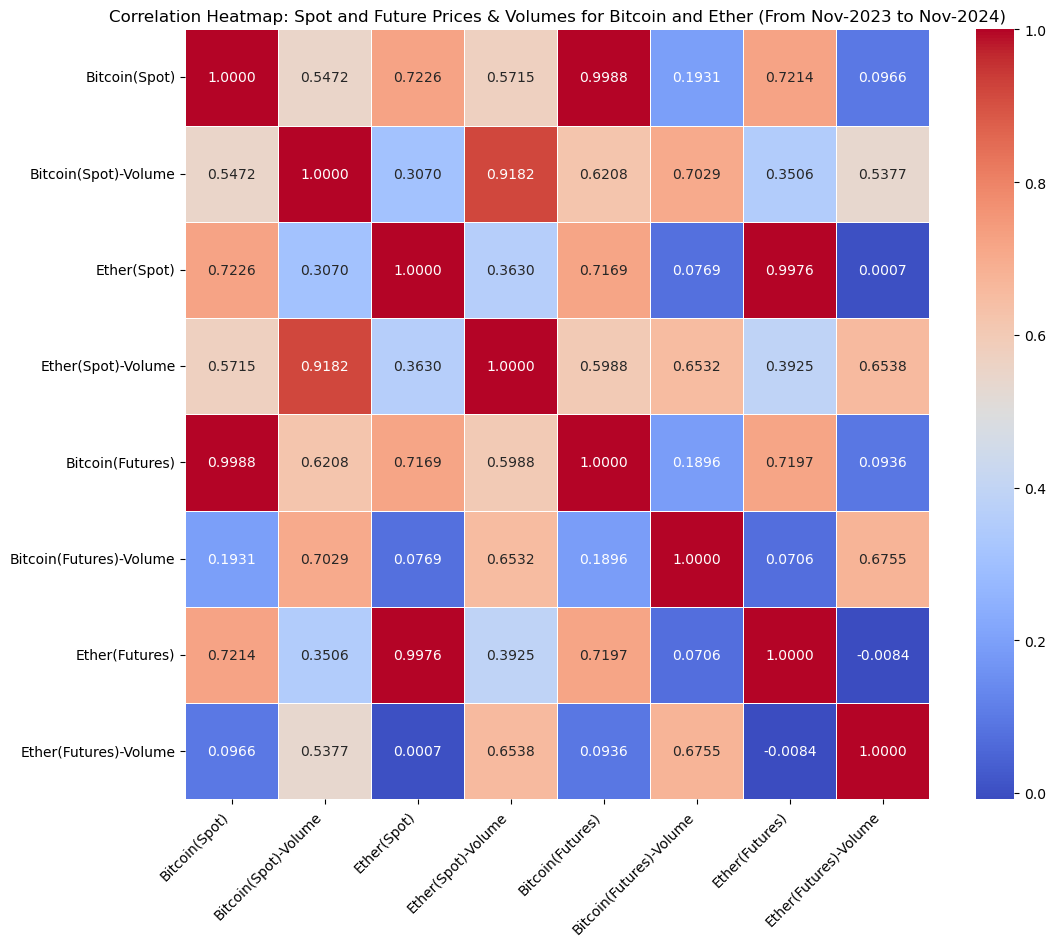

In [89]:
# Cryptocurrency (Spot & Futures)-Correlation Heatmap
# Date Range: Nov 2023 ~ Nov 2024 (1 yrs)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_crypto_1yr_full, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Volume", "Ether(Futures)", "Ether(Futures)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Spot and Future Prices & Volumes for Bitcoin and Ether (From Nov-2023 to Nov-2024)')

plt.savefig('outputs/heatmap_crypto_spotFutures_1yr.png', dpi=300)

plt.show()

In [90]:
# Calculate the correlation difference
# dataframe 1 = corr_crypto_1yr_full: Nov 2023 ~ Nov 2024
# dataframe 2 = corr_crypto_2yrs_full: Nov 2022 ~ Nov 2024
comparison_matrix_crypto1Yr = compare_correlation(corr_crypto_1yr_full, corr_crypto_2yrs_full)
comparison_matrix_crypto1Yr

close_b volume_b close_eth volume_eth close_b_f volume_b_f  \
close_b         Same     High       Low        Low       Low        Low   
volume_b        High     Same       Low       High      High       High   
close_eth        Low      Low      Same        Low       Low        Low   
volume_eth       Low     High       Low       Same       Low       High   
close_b_f        Low     High       Low        Low      Same        Low   
volume_b_f       Low     High       Low       High       Low       Same   
close_eth_f      Low      Low       Low        Low       Low        Low   
volume_eth_f     Low      Low       Low       High       Low        Low   

             close_eth_f volume_eth_f  
close_b              Low          Low  
volume_b             Low          Low  
close_eth            Low          Low  
volume_eth           Low         High  
close_b_f            Low          Low  
volume_b_f           Low          Low  
close_eth_f         Same          Low  
volume_eth_f         Low         Same

In [91]:
# Percentage Change in Correlation (Nov 2023 - Nov 2024 vs. Nov 2022 - Nov 2024)/ 1 yr v.s. 2 yrs
percent_change_fullCrypto_1yr = correlation_change(corr_crypto_1yr_full, corr_crypto_2yrs_full)
percent_change_fullCrypto_1yr

close_b   volume_b  close_eth  volume_eth  close_b_f  \
close_b        0.000000   7.700286 -21.538010  -14.180210  -0.086812   
volume_b       7.700286   0.000000 -25.534236    0.442242   8.926474   
close_eth    -21.538010 -25.534236   0.000000  -37.684872 -21.934135   
volume_eth   -14.180210   0.442242 -37.684872    0.000000 -14.227983   
close_b_f     -0.086812   8.926474 -21.934135  -14.227983   0.000000   
volume_b_f   -26.318756   3.516495 -64.221790    6.120035 -27.250808   
close_eth_f  -21.554541 -24.393228  -0.155429  -36.271120 -21.710301   
volume_eth_f  -3.138765 -11.123386 -98.820980   10.739360  -4.890199   

              volume_b_f  close_eth_f  volume_eth_f  
close_b       -26.318756   -21.554541     -3.138765  
volume_b        3.516495   -24.393228    -11.123386  
close_eth     -64.221790    -0.155429    -98.820980  
volume_eth      6.120035   -36.271120     10.739360  
close_b_f     -27.250808   -21.710301     -4.890199  
volume_b_f      0.000000   -66.744512    -11.575497  
close_eth_f   -66.744512     0.000000   -114.216349  
volume_eth_f  -11.575497  -114.216349      0.000000

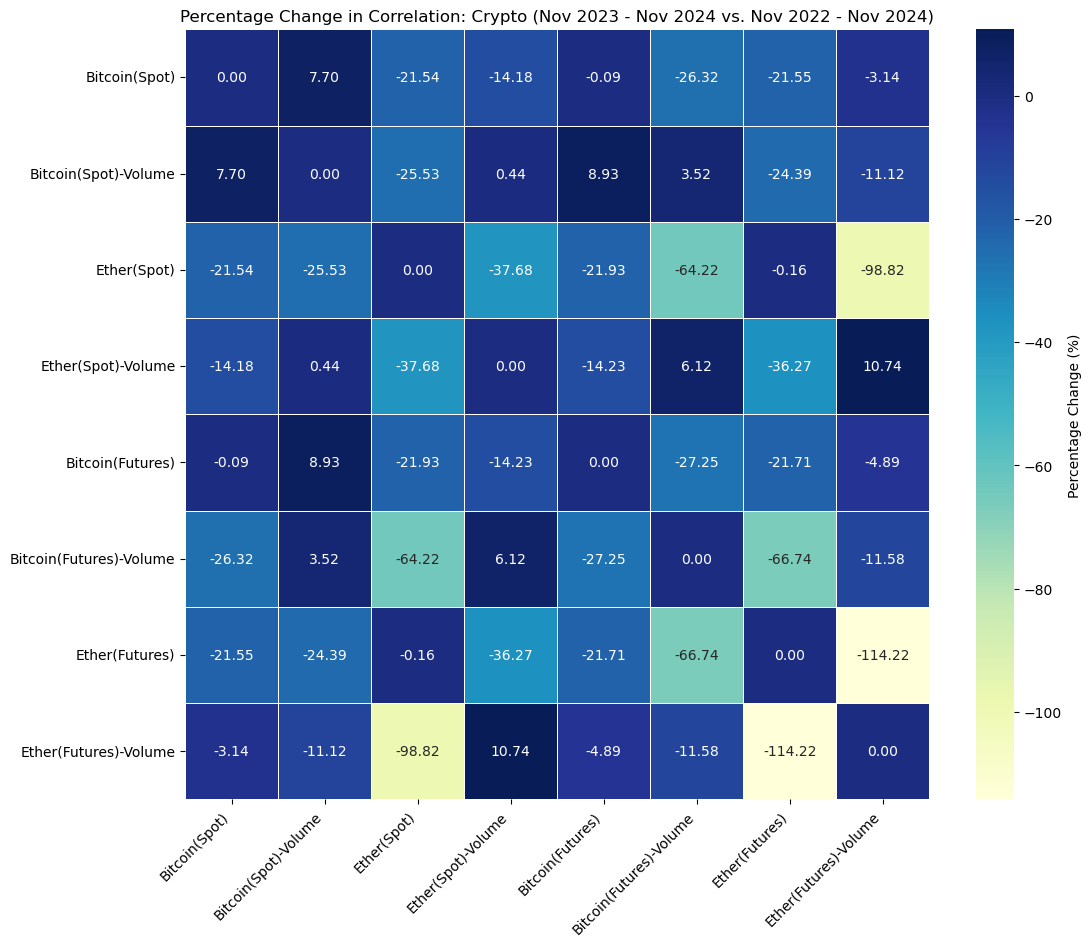

In [92]:
# Percentage Change in Correlation (Nov 2023 - Nov 2024 vs. Nov 2022 - Nov 2024)
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(percent_change_fullCrypto_1yr, annot=True,fmt=".2f",cmap='YlGnBu', linewidths=0.5,
                     cbar_kws={'label': 'Percentage Change (%)'})

tick_labels = ["Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume", 
               "Bitcoin(Futures)", "Bitcoin(Futures)-Volume", "Ether(Futures)", "Ether(Futures)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=45,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Percentage Change in Correlation: Crypto (Nov 2023 - Nov 2024 vs. Nov 2022 - Nov 2024)')

plt.savefig('outputs/heatmap_changeinCorr_crypto_1yrs.png', dpi=300)

plt.show()

## 4.2 Cyrptocurrencies v.s. Copper/Aluminum
---
- **Heatmap Visualizations & Hypothesis Testing**
    - **4.2.1 Five-Year Period**: Nov 2019 – Nov 2024  
    - **4.2.2 COVID-19 Period**: Mar 2020 – May 2023  
    - **4.2.3 Post-COVID Period**: Jun 2023 – Nov 2024  

In [93]:
copper_daily = pd.read_csv("resources/copper_daily_f.csv")
alu_daily = pd.read_csv("resources/alu_daily_f.csv")
gold_daily = pd.read_csv("resources/gold_daily_f.csv")

In [94]:
copper_daily.head()

Date    Open    High     Low   Close  Adj Close  Volume
0  2014-11-03  3.0515  3.0795  3.0500  3.0795     3.0795     182
1  2014-11-04  3.0575  3.0575  3.0205  3.0335     3.0335     217
2  2014-11-05  3.0095  3.0225  3.0050  3.0225     3.0225     302
3  2014-11-06  3.0185  3.0340  3.0185  3.0305     3.0305     208
4  2014-11-07  3.0300  3.0550  3.0300  3.0525     3.0525     241

In [95]:
copper_daily_df = copper_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_cop', 'Volume': 'volume_cop'})
alu_daily_df = alu_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_alu', 'Volume': 'volume_alu'})
gold_daily_df = gold_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_gold', 'Volume': 'volume_gold'})


In [96]:
copper_daily_df = copper_daily[['Date', 'Close', 'Volume']].assign(
        Close=lambda x: x['Close'] * 2204.62).rename(columns={'Close': 'close_cop', 'Volume': 'volume_cop'})
alu_daily_df = alu_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_alu', 'Volume': 'volume_alu'})
gold_daily_df = gold_daily[['Date', 'Close', 'Volume']].rename(columns={'Close': 'close_gold', 'Volume': 'volume_gold'})


In [97]:
for df in [copper_daily_df, alu_daily_df,gold_daily_df]:
    df['Date'] = pd.to_datetime(df['Date'])

In [98]:
merged_df = pd.merge(copper_daily_df,alu_daily_df, on='Date', how='left')
comm_daily_df = pd.merge(merged_df,gold_daily_df, on='Date', how='left').rename(columns = {"Date":"date"})
comm_daily_df.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
2529 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
2530 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
2531 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
2532 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
2533 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

      volume_gold  
2529         41.0  
2530         94.0  
2531     177858.0  
2532      61653.0  
2533       3861.0

In [99]:
comm_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2534 entries, 0 to 2533
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2534 non-null   datetime64[ns]
 1   close_cop    2534 non-null   float64       
 2   volume_cop   2534 non-null   int64         
 3   close_alu    2498 non-null   float64       
 4   volume_alu   2498 non-null   float64       
 5   close_gold   2533 non-null   float64       
 6   volume_gold  2533 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 158.4 KB


In [100]:
# Missing data (Time frame)
# Gold:11-23-2023
# Aluminum: 09-06-2016 ~ 09-28-2016 ; 10-06-2016 ~ 10-27-2016 ; 07-06-2017 ~ 07-10-2017 ; 11-23-2023
comm_daily_df[comm_daily_df['close_alu'].isna()]

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
463  2016-09-06  4594.428324         800        NaN         NaN  1349.400024   
464  2016-09-07  4614.269517         478        NaN         NaN  1344.300049   
465  2016-09-08  4620.883423         429        NaN         NaN  1336.800049   
466  2016-09-09  4604.348920         662        NaN         NaN  1330.099976   
467  2016-09-12  4620.883423         357        NaN         NaN  1321.000000   
468  2016-09-13  4619.781193         474        NaN         NaN  1319.000000   
469  2016-09-14  4735.523764         815        NaN         NaN  1321.500000   
470  2016-09-15  4744.342131        1067        NaN         NaN  1313.500000   
471  2016-09-16  4743.239901         418        NaN         NaN  1305.800049   
472  2016-09-19  4737.728224         550        NaN         NaN  1313.500000   
473  2016-09-20  4752.058267         505        NaN         NaN  1313.699951   
474  2016-09-21  4728.909858         484        NaN         NaN  1326.900024   
475  2016-09-22  4822.606250         793        NaN         NaN  1340.400024   
476  2016-09-23  4833.629602         723        NaN         NaN  1337.199951   
477  2016-09-26  4828.117926         745        NaN         NaN  1339.699951   
478  2016-09-27  4765.286080         506        NaN         NaN  1325.900024   
479  2016-09-28  4804.969517         830        NaN         NaN  1319.400024   
485  2016-10-06  4735.523764         223        NaN         NaN  1249.800049   
486  2016-10-07  4754.263253         259        NaN         NaN  1248.900024   
487  2016-10-11  4802.764531         475        NaN         NaN  1253.000000   
488  2016-10-12  4782.923338         191        NaN         NaN  1251.099976   
489  2016-10-13  4662.771321         422        NaN         NaN  1255.000000   
490  2016-10-14  4637.417926         191        NaN         NaN  1253.099976   
491  2016-10-17  4628.599560         279        NaN         NaN  1254.400024   
492  2016-10-18  4625.292869         342        NaN         NaN  1260.800049   
493  2016-10-19  4623.087883         281        NaN         NaN  1267.900024   
494  2016-10-20  4608.758367         188        NaN         NaN  1265.599976   
495  2016-10-21  4593.325568         183        NaN         NaN  1265.900024   
496  2016-10-24  4602.144460         250        NaN         NaN  1262.000000   
497  2016-10-25  4701.352003         420        NaN         NaN  1271.900024   
498  2016-10-26  4716.784276         235        NaN         NaN  1264.800049   
499  2016-10-27  4774.104446         684        NaN         NaN  1267.900024   
670  2017-07-06  5845.549901         593        NaN         NaN  1222.199951   
671  2017-07-07  5814.685355         556        NaN         NaN  1208.599976   
672  2017-07-10  5819.094276         903        NaN         NaN  1212.099976   
2277 2023-11-23  8331.259077         596        NaN         NaN          NaN   

      volume_gold  
463          46.0  
464          14.0  
465          30.0  
466          35.0  
467         177.0  
468          79.0  
469          73.0  
470          37.0  
471           4.0  
472          20.0  
473          97.0  
474          76.0  
475          23.0  
476          40.0  
477          24.0  
478          48.0  
479       10551.0  
485         114.0  
486         169.0  
487          26.0  
488         127.0  
489         315.0  
490         311.0  
491          41.0  
492          11.0  
493         219.0  
494         415.0  
495         224.0  
496          42.0  
497          61.0  
498         279.0  
499         338.0  
670           5.0  
671         116.0  
672          28.0  
2277          NaN

In [101]:
comm_daily_df = comm_daily_df.dropna(subset=['close_alu']).reset_index(drop=True)
comm_daily_df.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
2493 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
2494 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
2495 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
2496 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
2497 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

      volume_gold  
2493         41.0  
2494         94.0  
2495     177858.0  
2496      61653.0  
2497       3861.0

In [102]:
comm_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2498 non-null   datetime64[ns]
 1   close_cop    2498 non-null   float64       
 2   volume_cop   2498 non-null   int64         
 3   close_alu    2498 non-null   float64       
 4   volume_alu   2498 non-null   float64       
 5   close_gold   2498 non-null   float64       
 6   volume_gold  2498 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 136.7 KB


### 4.2.1 Five-Year Period: Nov 2019 – Nov 2024  

In [103]:
comm_daily_df_5yr = comm_daily_df[(comm_daily_df['date'] >= '2019-11-01')&
                                  (comm_daily_df['date'] <= '2024-11-29')].reset_index(drop=True)

comm_crypto_df_5yr = pd.merge(comm_daily_df_5yr,crypto_spot_5yr_df, on='date', how='left')
comm_crypto_df_5yr.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
1273 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
1274 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
1275 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
1276 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
1277 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

      volume_gold       close_b     volume_b    close_eth   volume_eth  
1273         41.0  98997.664062  78473580551  3331.600830  36775716442  
1274         94.0  93102.296875  80909462490  3413.543945  51544793988  
1275     177858.0  91985.320312  91656519855  3326.517334  39902959158  
1276      61653.0  95962.531250  71133452438  3657.249268  43383987191  
1277       3861.0  97461.523438  54968682476  3593.494385  27622629486

In [104]:
corr_comm_crypto_5yr = comm_crypto_df_5yr.drop(columns=['date']).corr()
corr_comm_crypto_5yr

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.001476   0.865983    0.051616    0.492208   
volume_cop    0.001476    1.000000  -0.003630    0.064468   -0.012766   
close_alu     0.865983   -0.003630   1.000000   -0.015777    0.256756   
volume_alu    0.051616    0.064468  -0.015777    1.000000    0.190383   
close_gold    0.492208   -0.012766   0.256756    0.190383    1.000000   
volume_gold  -0.024773    0.281861  -0.016240    0.058097   -0.021292   
close_b       0.767895    0.008247   0.557558    0.065255    0.702421   
volume_b      0.100405    0.019420   0.005795   -0.150675    0.058788   
close_eth     0.861536   -0.006600   0.753121    0.053381    0.484850   
volume_eth    0.270959    0.024635   0.157498   -0.167544    0.078043   

             volume_gold   close_b  volume_b  close_eth  volume_eth  
close_cop      -0.024773  0.767895  0.100405   0.861536    0.270959  
volume_cop      0.281861  0.008247  0.019420  -0.006600    0.024635  
close_alu      -0.016240  0.557558  0.005795   0.753121    0.157498  
volume_alu      0.058097  0.065255 -0.150675   0.053381   -0.167544  
close_gold     -0.021292  0.702421  0.058788   0.484850    0.078043  
volume_gold     1.000000 -0.003712 -0.004739  -0.013632   -0.001483  
close_b        -0.003712  1.000000  0.308579   0.873117    0.394723  
volume_b       -0.004739  0.308579  1.000000   0.131621    0.788068  
close_eth      -0.013632  0.873117  0.131621   1.000000    0.309113  
volume_eth     -0.001483  0.394723  0.788068   0.309113    1.000000

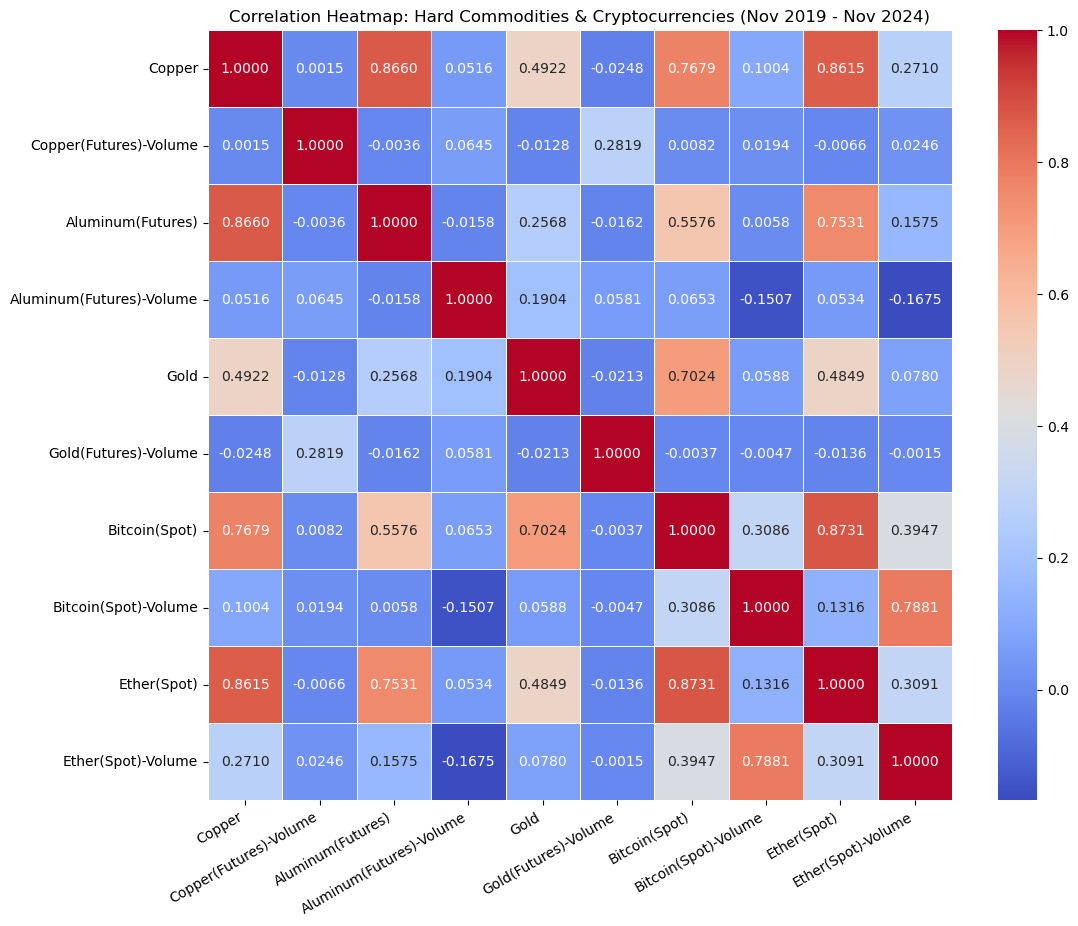

In [105]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_comm_crypto_5yr, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Copper", "Copper(Futures)-Volume", "Aluminum(Futures)", "Aluminum(Futures)-Volume",
               "Gold", "Gold(Futures)-Volume",
                "Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=30,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities & Cryptocurrencies (Nov 2019 - Nov 2024)')

plt.savefig('outputs/heatmap_crypto_comm_5yrs.png', dpi=300)

plt.show()


In [106]:
def plot_comm_vs_factor(comm_value, comm_label, factor_value, factor_label, time_frame, factor_df, comm_df):
  
    fig = go.Figure()


    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=comm_df[comm_value], 
        mode='lines', 
        name=comm_label
    ))
        

    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=factor_df[factor_value], 
        mode='lines', 
        name=factor_label, 
        yaxis='y2'
    ))

    

    date_num = comm_df['date'].map(pd.Timestamp.toordinal)

    slope_comm, intercept_comm, *_ = linregress(date_num, comm_df[comm_value])
    comm_trendline = slope_comm * date_num + intercept_comm
    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=comm_trendline, 
        mode='lines', 
        name=f'{comm_label} Trendline', 
        line=dict(dash='dash', color='blue')
    ))


    slope_factor, intercept_factor, *_ = linregress(date_num, factor_df[factor_value])
    factor_trendline = slope_factor * date_num + intercept_factor
    fig.add_trace(go.Scatter(
        x=comm_df['date'], 
        y=factor_trendline, 
        mode='lines', 
        name=f'{factor_label} Trendline', 
        line=dict(dash='dash', color='red'),
        yaxis='y2'
    ))


    fig.update_layout(
        title=f'{comm_label} with {factor_label} ({time_frame})',
        xaxis_title='Date',
        yaxis=dict(
            title=f'{comm_label}(USD/Metric Ton)',
            titlefont=dict(color='blue'),
            tickfont=dict(color='blue'),
        ),
        yaxis2=dict(
            title=factor_label,
            titlefont=dict(color='red'),
            tickfont=dict(color='red'),
            overlaying='y',
            side='right'
        ),
        legend=dict(x=1.1, y=1), 
        template='plotly_white',
    )

    fig.show()

    
    correlation, _ = pearsonr(factor_df[factor_value], comm_df[comm_value])

    
    print(f"Quick Summary")
    print(f"--------------")
    print(f"The Pearson correlation between {comm_label} and {factor_label} is: {round(correlation, 3)}")
    print(f"The slope of the {comm_label} trendline is: {round(slope_comm, 6)}")
    print(f"The slope of the {factor_label} trendline is: {round(slope_factor, 6)}")

In [107]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Daily Close Price',
    factor_value='close_b', 
    factor_label='Bitcoin Spot Price',
    time_frame = 'From Nov-2019 to Nov-2024',
    factor_df=comm_crypto_df_5yr, 
    comm_df=comm_crypto_df_5yr
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Daily Close Price and Bitcoin Spot Price is: 0.768
The slope of the Copper Futures Daily Close Price trendline is: 1.572618
The slope of the Bitcoin Spot Price trendline is: 23.271827


In [108]:
plot_comm_vs_factor(
    comm_value='close_alu', 
    comm_label='Aluminum Futures Daily Close Price',
    factor_value='close_eth', 
    factor_label='Ether Spot Price',
    time_frame = 'From Nov-2019 to Nov-2024',
    factor_df=comm_crypto_df_5yr, 
    comm_df=comm_crypto_df_5yr
)

Quick Summary
--------------
The Pearson correlation between Aluminum Futures Daily Close Price and Ether Spot Price is: 0.753
The slope of the Aluminum Futures Daily Close Price trendline is: 0.32196
The slope of the Ether Spot Price trendline is: 1.254364


### 4.2.2 COVID-19 Period: Mar 2020 – May 2023  

In [109]:
start_date = '2020-03-01'
end_date = '2023-05-31'

comm_crypto_df_covid = pd.merge(comm_daily_df[(comm_daily_df['date'] >= start_date) & (comm_daily_df['date'] <= end_date)], 
                     crypto_spot_df[(crypto_spot_df['date'] >= start_date) & (crypto_spot_df['date'] <= end_date)], 
                     on='date', how='left')

comm_crypto_df_covid.tail()


date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
814 2023-05-24  7834.117031         553    2230.00        21.0  1962.800049   
815 2023-05-25  7893.641662         546    2233.25        16.0  1943.099976   
816 2023-05-26  8098.671705         660    2245.00       228.0  1944.099976   
817 2023-05-30  8064.499943        1442    2227.75        39.0  1958.000000   
818 2023-05-31  8004.975313         484    2255.50        18.0  1963.900024   

     volume_gold       close_b     volume_b    close_eth  volume_eth  
814        189.0  26334.818359  16299104428  1800.099976  7101647419  
815          1.0  26476.207031  13851122697  1805.953735  6321689859  
816     166036.0  26719.291016  12711619225  1828.689697  5451414258  
817      37838.0  27702.349609  13251081851  1901.026611  5363439784  
818       5959.0  27219.658203  15656371534  1874.130493  5984512548

In [110]:
corr_comm_crypto_covid = comm_crypto_df_covid.drop(columns=['date']).corr()
corr_comm_crypto_covid

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.028496   0.889736    0.006086    0.323422   
volume_cop    0.028496    1.000000   0.009345    0.055877    0.003661   
close_alu     0.889736    0.009345   1.000000   -0.004184    0.247907   
volume_alu    0.006086    0.055877  -0.004184    1.000000    0.125809   
close_gold    0.323422    0.003661   0.247907    0.125809    1.000000   
volume_gold   0.003147    0.198198  -0.000647    0.147164    0.008763   
close_b       0.808318    0.027440   0.668549   -0.080287    0.076254   
volume_b      0.065414    0.003667  -0.085557   -0.137718   -0.233288   
close_eth     0.851365    0.005204   0.809437   -0.042752    0.123226   
volume_eth    0.279945    0.016385   0.089879   -0.151094   -0.118131   

             volume_gold   close_b  volume_b  close_eth  volume_eth  
close_cop       0.003147  0.808318  0.065414   0.851365    0.279945  
volume_cop      0.198198  0.027440  0.003667   0.005204    0.016385  
close_alu      -0.000647  0.668549 -0.085557   0.809437    0.089879  
volume_alu      0.147164 -0.080287 -0.137718  -0.042752   -0.151094  
close_gold      0.008763  0.076254 -0.233288   0.123226   -0.118131  
volume_gold     1.000000  0.000634 -0.011588  -0.006122    0.002121  
close_b         0.000634  1.000000  0.281753   0.883918    0.458543  
volume_b       -0.011588  0.281753  1.000000   0.055851    0.719196  
close_eth      -0.006122  0.883918  0.055851   1.000000    0.303536  
volume_eth      0.002121  0.458543  0.719196   0.303536    1.000000

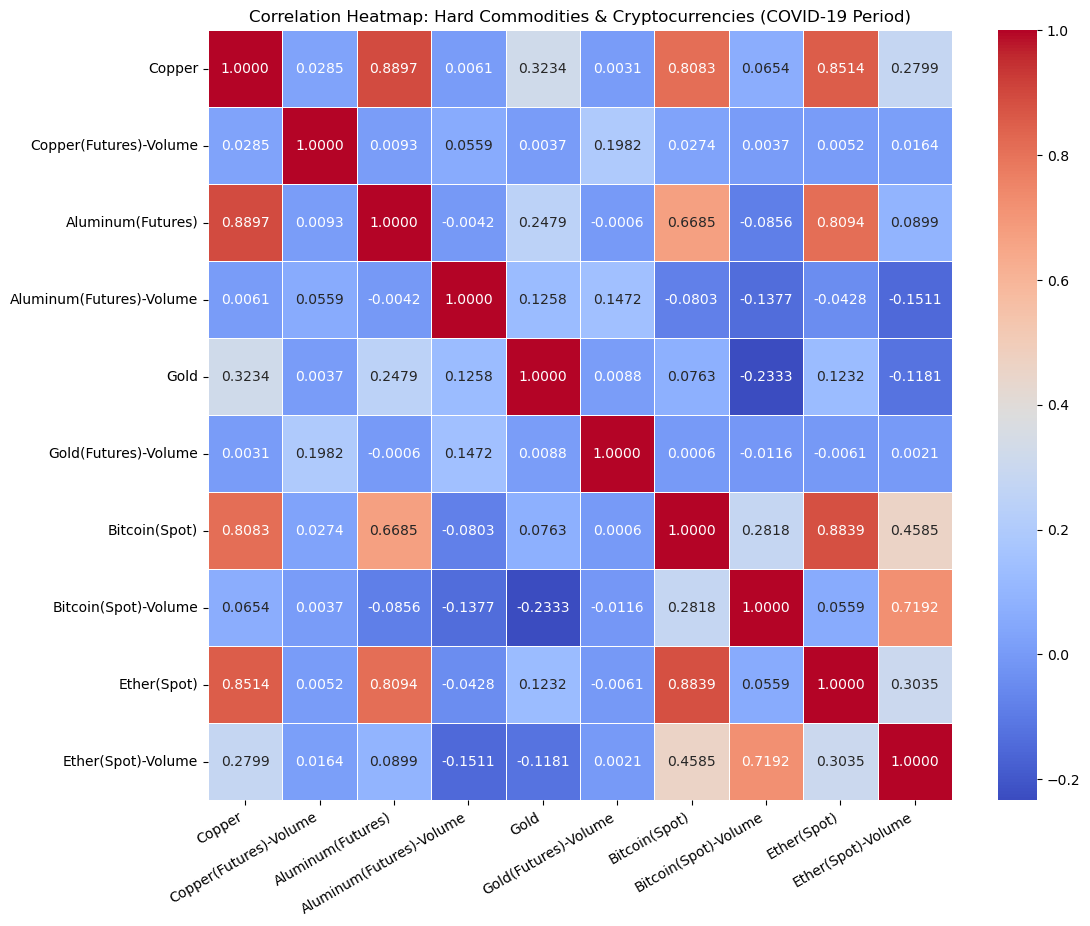

In [111]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_comm_crypto_covid, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Copper", "Copper(Futures)-Volume", "Aluminum(Futures)", "Aluminum(Futures)-Volume",
               "Gold", "Gold(Futures)-Volume",
                "Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=30,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities & Cryptocurrencies (COVID-19 Period)')

plt.savefig('outputs/heatmap_crypto_comm_covid.png', dpi=300)

plt.show()

In [112]:
# Calculate the correlation difference
# dataframe 1 = corr_comm_crypto_covid: Mar 2020 ~ May 2023
# dataframe 2 = corr_comm_crypto_5yr: Nov 2019 ~ Nov 2024
comparison_matrix_commCrypto1 = compare_correlation(corr_comm_crypto_covid, corr_comm_crypto_5yr)
comparison_matrix_commCrypto1

close_cop volume_cop close_alu volume_alu close_gold volume_gold  \
close_cop        Same       High      High        Low        Low        High   
volume_cop       High       Same      High        Low       High         Low   
close_alu        High       High      Same       High        Low        High   
volume_alu        Low        Low      High       Same        Low        High   
close_gold        Low       High       Low        Low       Same        High   
volume_gold      High        Low      High       High       High        Same   
close_b          High       High      High        Low        Low        High   
volume_b          Low        Low       Low       High        Low         Low   
close_eth         Low       High      High        Low        Low        High   
volume_eth       High        Low       Low       High        Low        High   

            close_b volume_b close_eth volume_eth  
close_cop      High      Low       Low       High  
volume_cop     High      Low      High        Low  
close_alu      High      Low      High        Low  
volume_alu      Low     High       Low       High  
close_gold      Low      Low       Low        Low  
volume_gold    High      Low      High       High  
close_b        Same      Low      High       High  
volume_b        Low     Same       Low        Low  
close_eth      High      Low      Same        Low  
volume_eth     High      Low       Low       Same

In [113]:
comparison_matrix_commCrypto1.to_csv("outputs/matrix_comm_crypto_covid5Yr.csv", index=True)

In [114]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Daily Close Price',
    factor_value='close_b', 
    factor_label='Bitcoin Spot Price',
    time_frame = 'From Mar-2020 to May-2023',
    factor_df=comm_crypto_df_covid, 
    comm_df=comm_crypto_df_covid,
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Daily Close Price and Bitcoin Spot Price is: 0.808
The slope of the Copper Futures Daily Close Price trendline is: 2.386595
The slope of the Bitcoin Spot Price trendline is: 8.401279


In [115]:
plot_comm_vs_factor(
    comm_value='close_alu', 
    comm_label='Aluminum Futures Daily Close Price',
    factor_value='close_eth', 
    factor_label='Ether Spot Price',
    time_frame = 'From Mar-2020 to May-2023',
    factor_df=comm_crypto_df_covid, 
    comm_df=comm_crypto_df_covid
)

Quick Summary
--------------
The Pearson correlation between Aluminum Futures Daily Close Price and Ether Spot Price is: 0.809
The slope of the Aluminum Futures Daily Close Price trendline is: 0.834319
The slope of the Ether Spot Price trendline is: 1.338582


### 4.2.3 Post-COVID Period: Jun 2023 – Nov 2024  

In [116]:
start_date = '2023-06-01'
end_date = '2024-11-30'

comm_crypto_df_pcovid = pd.merge(comm_daily_df[(comm_daily_df['date'] >= start_date) & (comm_daily_df['date'] <= end_date)], 
                     crypto_spot_df[(crypto_spot_df['date'] >= start_date) & (crypto_spot_df['date'] <= end_date)], 
                     on='date', how='left')

comm_crypto_df_pcovid.tail()

date    close_cop  volume_cop  close_alu  volume_alu   close_gold  \
373 2024-11-22  8981.621619         514    2556.00         0.0  2709.899902   
374 2024-11-25  9020.202301         335    2580.75         0.0  2616.800049   
375 2024-11-26  8904.460256       37274    2555.25        14.0  2620.300049   
376 2024-11-27  8966.189347       11425    2556.50         0.0  2639.899902   
377 2024-11-29  8995.952188        1274    2562.00        12.0  2657.000000   

     volume_gold       close_b     volume_b    close_eth   volume_eth  
373         41.0  98997.664062  78473580551  3331.600830  36775716442  
374         94.0  93102.296875  80909462490  3413.543945  51544793988  
375     177858.0  91985.320312  91656519855  3326.517334  39902959158  
376      61653.0  95962.531250  71133452438  3657.249268  43383987191  
377       3861.0  97461.523438  54968682476  3593.494385  27622629486

In [117]:
corr_comm_crypto_pcovid = comm_crypto_df_pcovid.drop(columns=['date']).corr()
corr_comm_crypto_pcovid

close_cop  volume_cop  close_alu  volume_alu  close_gold  \
close_cop     1.000000    0.030792   0.841400   -0.206770    0.744542   
volume_cop    0.030792    1.000000   0.046162    0.133706    0.022668   
close_alu     0.841400    0.046162   1.000000   -0.192806    0.783928   
volume_alu   -0.206770    0.133706  -0.192806    1.000000   -0.146373   
close_gold    0.744542    0.022668   0.783928   -0.146373    1.000000   
volume_gold  -0.004711    0.292274   0.008522   -0.001705    0.010545   
close_b       0.707680    0.056017   0.711409   -0.202322    0.853687   
volume_b      0.287633    0.052806   0.363566   -0.134512    0.551393   
close_eth     0.688881    0.055159   0.536901   -0.196204    0.582794   
volume_eth    0.364940    0.036742   0.398364   -0.152817    0.572758   

             volume_gold   close_b  volume_b  close_eth  volume_eth  
close_cop      -0.004711  0.707680  0.287633   0.688881    0.364940  
volume_cop      0.292274  0.056017  0.052806   0.055159    0.036742  
close_alu       0.008522  0.711409  0.363566   0.536901    0.398364  
volume_alu     -0.001705 -0.202322 -0.134512  -0.196204   -0.152817  
close_gold      0.010545  0.853687  0.551393   0.582794    0.572758  
volume_gold     1.000000  0.070956  0.037152   0.077509    0.037963  
close_b         0.070956  1.000000  0.732682   0.873198    0.749052  
volume_b        0.037152  0.732682  1.000000   0.577993    0.939606  
close_eth       0.077509  0.873198  0.577993   1.000000    0.632096  
volume_eth      0.037963  0.749052  0.939606   0.632096    1.000000

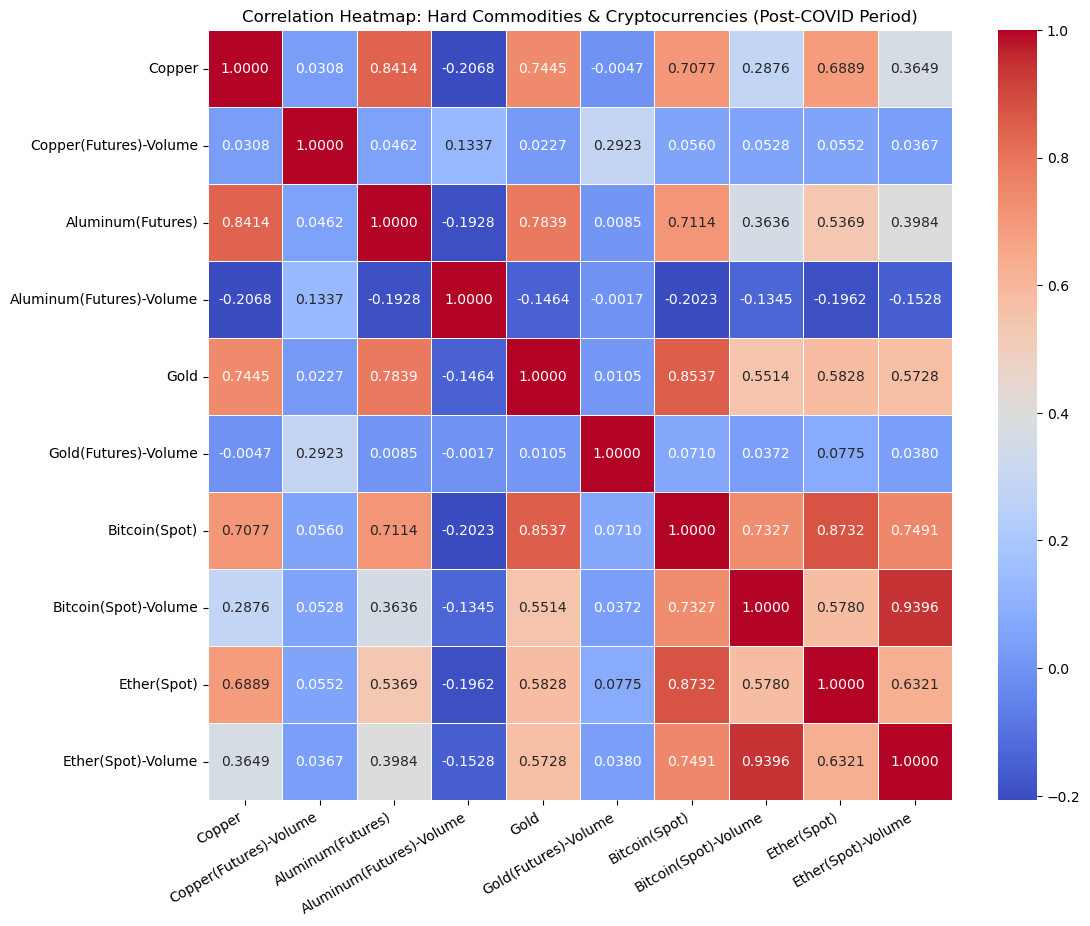

In [118]:
plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(corr_comm_crypto_pcovid, annot=True,fmt=".4f",cmap='coolwarm', linewidths=0.5)

tick_labels = ["Copper", "Copper(Futures)-Volume", "Aluminum(Futures)", "Aluminum(Futures)-Volume",
               "Gold", "Gold(Futures)-Volume",
                "Bitcoin(Spot)", "Bitcoin(Spot)-Volume", "Ether(Spot)", "Ether(Spot)-Volume"]

heatmap.set_xticklabels(tick_labels, rotation=30,ha='right')
heatmap.set_yticklabels(tick_labels, rotation=0)

plt.title('Correlation Heatmap: Hard Commodities & Cryptocurrencies (Post-COVID Period)')

plt.savefig('outputs/heatmap_crypto_comm_postCovid.png', dpi=300)

plt.show()

In [119]:
# Calculate the correlation difference
# dataframe 1 = corr_comm_crypto_pcovid: Jun 2023 ~ Nov 2024
# dataframe 2 = corr_comm_crypto_covid: Mar 2020 ~ May 2023
comparison_matrix_commCrypto2 = compare_correlation(corr_comm_crypto_pcovid, corr_comm_crypto_covid)
comparison_matrix_commCrypto2

close_cop volume_cop close_alu volume_alu close_gold volume_gold  \
close_cop        Same       High       Low        Low       High         Low   
volume_cop       High       Same      High       High       High        High   
close_alu         Low       High      Same        Low       High        High   
volume_alu        Low       High       Low       Same        Low         Low   
close_gold       High       High      High        Low       Same        High   
volume_gold       Low       High      High        Low       High        Same   
close_b           Low       High      High        Low       High        High   
volume_b         High       High      High       High       High        High   
close_eth         Low       High       Low        Low       High        High   
volume_eth       High       High      High        Low       High        High   

            close_b volume_b close_eth volume_eth  
close_cop       Low     High       Low       High  
volume_cop     High     High      High       High  
close_alu      High     High       Low       High  
volume_alu      Low     High       Low        Low  
close_gold     High     High      High       High  
volume_gold    High     High      High       High  
close_b        Same     High       Low       High  
volume_b       High     Same      High       High  
close_eth       Low     High      Same       High  
volume_eth     High     High      High       Same

In [120]:
comparison_matrix_commCrypto2.to_csv("outputs/matrix_comm_crypto_pcovidCovid.csv", index=True)

In [121]:
plot_comm_vs_factor(
    comm_value='close_cop', 
    comm_label='Copper Futures Daily Close Price',
    factor_value='close_b', 
    factor_label='Bitcoin Spot Price',
    time_frame = 'From Jun-2023 to Nov-2024',
    factor_df=comm_crypto_df_pcovid, 
    comm_df=comm_crypto_df_pcovid
)

Quick Summary
--------------
The Pearson correlation between Copper Futures Daily Close Price and Bitcoin Spot Price is: 0.708
The slope of the Copper Futures Daily Close Price trendline is: 3.2826
The slope of the Bitcoin Spot Price trendline is: 102.009525


In [122]:
plot_comm_vs_factor(
    comm_value='close_alu', 
    comm_label='Aluminum Futures Daily Close Price',
    factor_value='close_eth', 
    factor_label='Ether Spot Price',
    time_frame = 'From Jun-2023 to Nov-2024',
    factor_df=comm_crypto_df_covid, 
    comm_df=comm_crypto_df_covid
)

Quick Summary
--------------
The Pearson correlation between Aluminum Futures Daily Close Price and Ether Spot Price is: 0.809
The slope of the Aluminum Futures Daily Close Price trendline is: 0.834319
The slope of the Ether Spot Price trendline is: 1.338582


# 5. Supporting Data Analysis  
---  
- **5.1 Variance Test**: Significant differences in variances between copper and aluminum prices  
- **5.2 Histograms**: Copper & Aluminum prices over the past decade  
- **5.3 US Housing Data**: Rent estimates and growth trends  

## 5.1 Variance Test

In [124]:
# Variance Test: Significant Difference Between Copper and Aluminum Prices (Past Decade)
var_copper = np.var(cpi_cop_alu_df['copper_value'], ddof=1)
var_aluminum = np.var(cpi_cop_alu_df['alu_value'], ddof=1)

F_statistic = var_copper / var_aluminum


df_copper = len(cpi_cop_alu_df) - 1
df_aluminum = df_copper

alpha = 0.05


lower_critical_value = f.ppf(alpha / 2, df_copper, df_aluminum)
upper_critical_value = f.ppf(1 - alpha / 2, df_copper, df_aluminum)


print(f"F-statistic: {F_statistic}")
print(f"Lower critical value: {lower_critical_value}")
print(f"Upper critical value: {upper_critical_value}")

if F_statistic < lower_critical_value or F_statistic > upper_critical_value:
    print("Reject the null hypothesis: Variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: Variances are not significantly different.")


F-statistic: 16.469276118151473
Lower critical value: 0.6979942452018365
Upper critical value: 1.4326765684304938
Reject the null hypothesis: Variances are significantly different.


In [125]:
# Variance Test: Significant Difference Between Copper and Aluminum Prices (COVID PeriodP)
var_copper = np.var(cpi_cop_alu_covid['copper_value'], ddof=1)
var_aluminum = np.var(cpi_cop_alu_covid['alu_value'], ddof=1)


F_statistic = var_copper / var_aluminum


df_copper = len(cpi_cop_alu_covid) - 1
df_aluminum = df_copper

alpha = 0.05

lower_critical_value = f.ppf(alpha / 2, df_copper, df_aluminum)
upper_critical_value = f.ppf(1 - alpha / 2, df_copper, df_aluminum)

print(f"F-statistic: {F_statistic}")
print(f"Lower critical value: {lower_critical_value}")
print(f"Upper critical value: {upper_critical_value}")

if F_statistic < lower_critical_value or F_statistic > upper_critical_value:
    print("Reject the null hypothesis: Variances are significantly different.")
else:
    print("Fail to reject the null hypothesis: Variances are not significantly different.")


F-statistic: 8.881472832264187
Lower critical value: 0.5243828442919567
Upper critical value: 1.9070036536955
Reject the null hypothesis: Variances are significantly different.


In [126]:
# Variance Test: if copper's variance is significant higher than aluminum prices (COVID Period)
var_copper = np.var(cpi_cop_alu_covid['copper_value'], ddof=1)  # Sample variance
var_aluminum = np.var(cpi_cop_alu_covid['alu_value'], ddof=1)

F_statistic = var_copper / var_aluminum

df_copper = len(cpi_cop_alu_covid) - 1
df_aluminum = df_copper

alpha = 0.05


upper_critical_value = f.ppf(1 - alpha, df_copper, df_aluminum)


print(f"F-statistic: {F_statistic}")
print(f"Critical value: {upper_critical_value}")


if F_statistic > upper_critical_value:
    print("Reject the null hypothesis: Variance of copper is significantly higher than that of aluminum.")
else:
    print("Fail to reject the null hypothesis: Variance of copper is not significantly higher than that of aluminum.")

F-statistic: 8.881472832264187
Critical value: 1.7166871444419058
Reject the null hypothesis: Variance of copper is significantly higher than that of aluminum.


## 5.2 Histograms

In [127]:
# Copper prices (Past Decade) 
fig = px.histogram(
    cpi_cop_alu_df,
    x='copper_value',
    nbins=30,
    title='Histogram of Copper Prices',
    template='plotly_white'
)


fig.update_layout(
    xaxis_title="Copper Price",
    yaxis_title="Frequency",
    bargap=0.1
)

fig.show()

In [128]:
# Aluminum prices (Past Decade)
fig = px.histogram(
    cpi_cop_alu_df,
    x='alu_value',
    nbins=30, 
    title='Histogram of Aluminum Prices',
    template='plotly_white'
)

# Customize layout
fig.update_layout(
    xaxis_title="Copper Price",
    yaxis_title="Frequency",
    bargap=0.1
)

fig.show()

## 5.3 US Housing Data  
---  
- **Data Type**:  
    - Rent Estimate  
    - Rent Growth  
- **Data Source**:  
    - [Apartment List](https://www.apartmentlist.com/research/category/data-rent-estimates)  

In [129]:
rent_df = pd.read_csv('resources/historical_rent_estimates.txt', delimiter=',')

In [130]:
rent_df = rent_df[rent_df["bed_size"] == "overall"]
rent_df.head()

location_name location_type  location_fips_code  population       state  \
0   United States      National                   0   331097593         NaN   
3      California         State                   6    39356104  California   
6           Texas         State                  48    29243342       Texas   
9         Florida         State                  12    21634529     Florida   
12       New York         State                  36    19994379    New York   

   county metro bed_size  2017_01  2017_02  ...  2024_02  2024_03  2024_04  \
0     NaN   NaN  overall   1070.0   1071.0  ...     1380     1389     1397   
3     NaN   NaN  overall   1740.0   1745.0  ...     2119     2135     2146   
6     NaN   NaN  overall   1054.0   1051.0  ...     1287     1290     1292   
9     NaN   NaN  overall   1074.0   1076.0  ...     1543     1550     1555   
12    NaN   NaN  overall   1429.0   1423.0  ...     1808     1826     1843   

    2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0      1404     1410     1413     1411     1404     1394     1382  
3      2154     2163     2170     2174     2168     2156     2142  
6      1295     1296     1297     1293     1286     1276     1266  
9      1558     1558     1555     1551     1543     1537     1529  
12     1867     1883     1892     1888     1874     1853     1840  

[5 rows x 103 columns]

In [131]:
rent_df_state = rent_df[rent_df["location_type"].isin(['National', 'State'])]
rent_df_state.head()

location_name location_type  location_fips_code  population       state  \
0   United States      National                   0   331097593         NaN   
3      California         State                   6    39356104  California   
6           Texas         State                  48    29243342       Texas   
9         Florida         State                  12    21634529     Florida   
12       New York         State                  36    19994379    New York   

   county metro bed_size  2017_01  2017_02  ...  2024_02  2024_03  2024_04  \
0     NaN   NaN  overall   1070.0   1071.0  ...     1380     1389     1397   
3     NaN   NaN  overall   1740.0   1745.0  ...     2119     2135     2146   
6     NaN   NaN  overall   1054.0   1051.0  ...     1287     1290     1292   
9     NaN   NaN  overall   1074.0   1076.0  ...     1543     1550     1555   
12    NaN   NaN  overall   1429.0   1423.0  ...     1808     1826     1843   

    2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0      1404     1410     1413     1411     1404     1394     1382  
3      2154     2163     2170     2174     2168     2156     2142  
6      1295     1296     1297     1293     1286     1276     1266  
9      1558     1558     1555     1551     1543     1537     1529  
12     1867     1883     1892     1888     1874     1853     1840  

[5 rows x 103 columns]

In [132]:
# Note: Maine,Vermont, West virginia, are three missed states and remove District of Columbia
print(rent_df_state[rent_df_state["location_type"]=="State"]["location_name"].unique())

['California' 'Texas' 'Florida' 'New York' 'Pennsylvania' 'Illinois'
 'Ohio' 'Georgia' 'North Carolina' 'Michigan' 'New Jersey' 'Virginia'
 'Washington' 'Arizona' 'Massachusetts' 'Tennessee' 'Indiana' 'Maryland'
 'Missouri' 'Wisconsin' 'Colorado' 'Minnesota' 'South Carolina' 'Alabama'
 'Louisiana' 'Kentucky' 'Oregon' 'Oklahoma' 'Connecticut' 'Utah' 'Iowa'
 'Nevada' 'Arkansas' 'Mississippi' 'Kansas' 'New Mexico' 'Nebraska'
 'Idaho' 'Hawaii' 'New Hampshire' 'Rhode Island' 'Montana' 'Delaware'
 'South Dakota' 'North Dakota' 'Alaska' 'District of Columbia' 'Wyoming']


In [133]:
rent_state_f = rent_df_state[rent_df_state['location_name'] != 'District of Columbia']
rent_state_f.head()

location_name location_type  location_fips_code  population       state  \
0   United States      National                   0   331097593         NaN   
3      California         State                   6    39356104  California   
6           Texas         State                  48    29243342       Texas   
9         Florida         State                  12    21634529     Florida   
12       New York         State                  36    19994379    New York   

   county metro bed_size  2017_01  2017_02  ...  2024_02  2024_03  2024_04  \
0     NaN   NaN  overall   1070.0   1071.0  ...     1380     1389     1397   
3     NaN   NaN  overall   1740.0   1745.0  ...     2119     2135     2146   
6     NaN   NaN  overall   1054.0   1051.0  ...     1287     1290     1292   
9     NaN   NaN  overall   1074.0   1076.0  ...     1543     1550     1555   
12    NaN   NaN  overall   1429.0   1423.0  ...     1808     1826     1843   

    2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0      1404     1410     1413     1411     1404     1394     1382  
3      2154     2163     2170     2174     2168     2156     2142  
6      1295     1296     1297     1293     1286     1276     1266  
9      1558     1558     1555     1551     1543     1537     1529  
12     1867     1883     1892     1888     1874     1853     1840  

[5 rows x 103 columns]

In [134]:
rent_df_long = rent_state_f.melt(
    id_vars=['location_name', 'location_type', 'location_fips_code', 'population', 'state', 'county', 'metro', 'bed_size'],
    var_name='year_month', 
    value_name='rent_amount'
)

final_rent_df = rent_df_long[
    ['location_name', 'location_type', 'location_fips_code', 'population', 
     'state', 'county', 'metro', 'bed_size', 'year_month', 'rent_amount']
]

final_rent_df['date'] = pd.to_datetime(final_rent_df['year_month'] + '_01', format='%Y_%m_%d')

final_rent_df = final_rent_df.drop(columns=['year_month'])


In [135]:
final_rent_df.tail()

location_name location_type  location_fips_code  population  \
4555      Delaware         State                  10      993635   
4556  South Dakota         State                  46      890342   
4557  North Dakota         State                  38      776874   
4558        Alaska         State                   2      734821   
4559       Wyoming         State                  56      577929   

             state county metro bed_size  rent_amount       date  
4555      Delaware    NaN   NaN  overall       1484.0 2024-11-01  
4556  South Dakota    NaN   NaN  overall        869.0 2024-11-01  
4557  North Dakota    NaN   NaN  overall       1105.0 2024-11-01  
4558        Alaska    NaN   NaN  overall       1599.0 2024-11-01  
4559       Wyoming    NaN   NaN  overall       1122.0 2024-11-01

In [136]:
final_rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   location_name       4560 non-null   object        
 1   location_type       4560 non-null   object        
 2   location_fips_code  4560 non-null   int64         
 3   population          4560 non-null   int64         
 4   state               4465 non-null   object        
 5   county              0 non-null      object        
 6   metro               0 non-null      object        
 7   bed_size            4560 non-null   object        
 8   rent_amount         4548 non-null   float64       
 9   date                4560 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 356.4+ KB


In [137]:
fig = px.line(
    final_rent_df[final_rent_df['location_name'].isin(['California','Texas',
                                                    'Florida','New York','Pennsylvania',
                                                   'Illinois','Ohio', 'Georgia', 'North Carolina','Michigan',
                                                   'New Jersey', 'Virginia','Washington','United States'])],
    x='date',
    y='rent_amount',
    color='location_name',
    title='US Rent Estimates (from Jan 2017 to Nov 2024)',
)


fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Monthly Rent Estimates($)",
    legend_title="Location",
    template="plotly_white",
)


for trace in fig.data:
    if trace.name == 'United States':
        trace.line.width = 4
        trace.opacity = 1
    else:
        trace.line.width = 2 
        trace.opacity = 0.3  


fig.show()

In [138]:
rentGrowth_monthly = pd.read_csv('resources/historical_rent_growth.txt', delimiter=',')

In [139]:
rentGrowth_monthly.head()

location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  2017_02  2017_03  2017_04  ...  2024_02  2024_03  2024_04  \
0    NaN   NaN   0.0005   0.0039   0.0071  ...   0.0025   0.0062   0.0055   
1    NaN   NaN   0.0024  -0.0003   0.0057  ...   0.0033   0.0073   0.0054   
2    NaN   NaN  -0.0022   0.0004   0.0049  ...   0.0003   0.0027   0.0013   
3    NaN   NaN   0.0016   0.0005   0.0051  ...   0.0033   0.0047   0.0032   
4    NaN   NaN  -0.0041   0.0004   0.0046  ...   0.0011   0.0096   0.0095   

   2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0   0.0056   0.0040   0.0023  -0.0013  -0.0051  -0.0076  -0.0082  
1   0.0036   0.0042   0.0032   0.0019  -0.0027  -0.0055  -0.0067  
2   0.0024   0.0010   0.0006  -0.0031  -0.0055  -0.0076  -0.0082  
3   0.0018  -0.0002  -0.0017  -0.0025  -0.0052  -0.0040  -0.0049  
4   0.0131   0.0085   0.0048  -0.0022  -0.0076  -0.0112  -0.0069  

[5 rows x 101 columns]

In [140]:
# Note: Maine,Vermont, West virginia, are three missed states and remove District of Columbia
print(rentGrowth_monthly[rentGrowth_monthly["location_type"]=="State"]["location_name"].unique())

['California' 'Texas' 'Florida' 'New York' 'Pennsylvania' 'Illinois'
 'Ohio' 'Georgia' 'North Carolina' 'Michigan' 'New Jersey' 'Virginia'
 'Washington' 'Arizona' 'Massachusetts' 'Tennessee' 'Indiana' 'Maryland'
 'Missouri' 'Wisconsin' 'Colorado' 'Minnesota' 'South Carolina' 'Alabama'
 'Louisiana' 'Kentucky' 'Oregon' 'Oklahoma' 'Connecticut' 'Utah' 'Iowa'
 'Nevada' 'Arkansas' 'Mississippi' 'Kansas' 'New Mexico' 'Nebraska'
 'Idaho' 'Hawaii' 'New Hampshire' 'Rhode Island' 'Montana' 'Delaware'
 'South Dakota' 'North Dakota' 'Alaska' 'District of Columbia' 'Wyoming']


In [141]:
rentGrowth_monthly_f = rentGrowth_monthly[rentGrowth_monthly['location_name'] != 'District of Columbia']
rentGrowth_monthly_f.head()


location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  2017_02  2017_03  2017_04  ...  2024_02  2024_03  2024_04  \
0    NaN   NaN   0.0005   0.0039   0.0071  ...   0.0025   0.0062   0.0055   
1    NaN   NaN   0.0024  -0.0003   0.0057  ...   0.0033   0.0073   0.0054   
2    NaN   NaN  -0.0022   0.0004   0.0049  ...   0.0003   0.0027   0.0013   
3    NaN   NaN   0.0016   0.0005   0.0051  ...   0.0033   0.0047   0.0032   
4    NaN   NaN  -0.0041   0.0004   0.0046  ...   0.0011   0.0096   0.0095   

   2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0   0.0056   0.0040   0.0023  -0.0013  -0.0051  -0.0076  -0.0082  
1   0.0036   0.0042   0.0032   0.0019  -0.0027  -0.0055  -0.0067  
2   0.0024   0.0010   0.0006  -0.0031  -0.0055  -0.0076  -0.0082  
3   0.0018  -0.0002  -0.0017  -0.0025  -0.0052  -0.0040  -0.0049  
4   0.0131   0.0085   0.0048  -0.0022  -0.0076  -0.0112  -0.0069  

[5 rows x 101 columns]

In [142]:
rentGrowth_monthly_f = rentGrowth_monthly_f[rentGrowth_monthly_f["location_type"].isin(['National', 'State'])]
rentGrowth_monthly_f.head()

location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  2017_02  2017_03  2017_04  ...  2024_02  2024_03  2024_04  \
0    NaN   NaN   0.0005   0.0039   0.0071  ...   0.0025   0.0062   0.0055   
1    NaN   NaN   0.0024  -0.0003   0.0057  ...   0.0033   0.0073   0.0054   
2    NaN   NaN  -0.0022   0.0004   0.0049  ...   0.0003   0.0027   0.0013   
3    NaN   NaN   0.0016   0.0005   0.0051  ...   0.0033   0.0047   0.0032   
4    NaN   NaN  -0.0041   0.0004   0.0046  ...   0.0011   0.0096   0.0095   

   2024_05  2024_06  2024_07  2024_08  2024_09  2024_10  2024_11  
0   0.0056   0.0040   0.0023  -0.0013  -0.0051  -0.0076  -0.0082  
1   0.0036   0.0042   0.0032   0.0019  -0.0027  -0.0055  -0.0067  
2   0.0024   0.0010   0.0006  -0.0031  -0.0055  -0.0076  -0.0082  
3   0.0018  -0.0002  -0.0017  -0.0025  -0.0052  -0.0040  -0.0049  
4   0.0131   0.0085   0.0048  -0.0022  -0.0076  -0.0112  -0.0069  

[5 rows x 101 columns]

In [143]:
rentGrowth_monthly_long = rentGrowth_monthly_f.melt(
    id_vars=['location_name', 'location_type', 'location_fips_code', 'population', 'state', 'county', 'metro'],
    var_name='year_month', 
    value_name='rent_growth'
)

final_rentGrowth_df = rentGrowth_monthly_long[
    ['location_name', 'location_type', 'location_fips_code', 'population', 
     'state', 'county', 'metro', 'year_month', 'rent_growth']
]

final_rentGrowth_df['date'] = pd.to_datetime(final_rentGrowth_df['year_month'] + '_01', format='%Y_%m_%d')

final_rentGrowth_df = final_rentGrowth_df.drop(columns=['year_month'])

In [144]:
final_rentGrowth_df.head()

location_name location_type  location_fips_code  population       state  \
0  United States      National                   0   331097593         NaN   
1     California         State                   6    39356104  California   
2          Texas         State                  48    29243342       Texas   
3        Florida         State                  12    21634529     Florida   
4       New York         State                  36    19994379    New York   

  county metro  rent_growth       date  
0    NaN   NaN       0.0005 2017-02-01  
1    NaN   NaN       0.0024 2017-02-01  
2    NaN   NaN      -0.0022 2017-02-01  
3    NaN   NaN       0.0016 2017-02-01  
4    NaN   NaN      -0.0041 2017-02-01

In [145]:
fig = px.line(
    final_rentGrowth_df[final_rentGrowth_df['location_name'].isin(['California','Texas',
                                                    'Florida','New York','Pennsylvania',
                                                   'Illinois','Ohio', 'Georgia', 'North Carolina','Michigan',
                                                   'New Jersey', 'Virginia','Washington','United States'])],
    x='date',
    y='rent_growth',
    color='location_name',
    title='US Rent Growth (from Feb 2017 to Nov 2024)',
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Monthly Rent Growth",
    legend_title="Location",
    template="plotly_white",
)



for trace in fig.data:
    if trace.name == 'United States':
        trace.line.width = 4  
        trace.opacity = 1
    else:
        trace.line.width = 2
        trace.opacity = 0.3 

fig.show()

In [146]:
cpi_df_201702_202411 = cpi_df[(cpi_df['Date'] >= '2017-02-01')&
                                  (cpi_df['Date'] <= '2024-11-01')].reset_index(drop=True)
cpi_df_201702_202411

Date  CPI_all_items  CPI_excl_food_energy  CPI_Energy  \
0  2017-02-01        2.81036               2.23535    15.72100   
1  2017-03-01        2.44120               2.04585    11.13623   
2  2017-04-01        2.17622               1.89657     8.69838   
3  2017-05-01        1.85634               1.73709     5.22440   
4  2017-06-01        1.64057               1.69912     2.54486   
..        ...            ...                   ...         ...   
89 2024-07-01        2.92357               3.21319     0.96254   
90 2024-08-01        2.59123               3.26556    -4.01051   
91 2024-09-01        2.40751               3.25871    -6.85852   
92 2024-10-01        2.57633               3.30004    -4.84854   
93 2024-11-01        2.73258               3.30015    -3.14935   

    CPI_Energy_Commo  CPI_Energy_Ser      PCE  
0           30.60916         3.71535  2.19714  
1           20.16245         3.34829  1.90636  
2           13.52599         4.32005  1.76747  
3            5.81187         4.68383  1.55777  
4            0.03194         4.96090  1.46555  
..               ...             ...      ...  
89          -2.07931         4.12569  2.46853  
90         -10.15275         3.03405  2.28331  
91         -15.31385         3.35753  2.10237  
92         -12.39927         4.00513  2.30767  
93          -8.45783         2.83076  2.44368  

[94 rows x 7 columns]

In [147]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=cpi_df_201702_202411['Date'], 
                         y=cpi_df_201702_202411['CPI_excl_food_energy'],
                         mode='lines', 
                         name='CPI_excl_food_energy',
                         line=dict(color='red')))


national = final_rentGrowth_df[final_rentGrowth_df['location_type'] == 'National']


fig.add_trace(go.Scatter(x=cpi_df_201702_202411['Date'], 
                         y=national['rent_growth']*100,
                         mode='lines',
                         name='Rent Growth',
                         line=dict(color='blue', dash='dash')))


fig.update_layout(
    title='Core CPI v.s. US Rent Growth (from Feb 2017 to Nov 2024)',
    xaxis_title='Time',
    yaxis_title='Percentage',
    showlegend=True,template='plotly_white',
)

fig.show()


correlation, _ = pearsonr(cpi_df_201702_202411['CPI_excl_food_energy'],national['rent_growth'])
print(f"Quick Summary")
print(f"--------------")
print(f"The Pearson correlation between Core CPI and US monthly rent growth is: {round(correlation,3)}")

Quick Summary
--------------
The Pearson correlation between Core CPI and US monthly rent growth is: 0.104


In [148]:
cpi_df_201701_202411 = cpi_df[(cpi_df['Date'] >= '2017-01-01')&
                                  (cpi_df['Date'] <= '2024-11-01')].reset_index(drop=True)

national_rent = final_rent_df[final_rent_df['location_type'] == 'National']

fig = go.Figure()

fig.add_trace(go.Scatter(x=cpi_df_201701_202411['Date'], 
                         y=national_rent['rent_amount'], 
                         mode='lines', name='Rent',
                         line=dict(color='blue', dash='dash')
                        ))

fig.add_trace(go.Scatter(x=cpi_df_201701_202411['Date'], 
                         y=cpi_df_201701_202411['CPI_excl_food_energy'], 
                         mode='lines', name='CPI', 
                         yaxis='y2'))


fig.update_layout(
    title='Core CPI v.s. US Rent Estimates (from Jan 2017 to Nov 2024)',
    xaxis_title='Date',
    yaxis=dict(
        title='Monthly Rent Estimates($)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='CPI',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=1, y=1),template='plotly_white',
)

fig.show()

correlation, _ = pearsonr(cpi_df_201701_202411['CPI_excl_food_energy'], national_rent['rent_amount'])
print(f"Quick Summary")
print(f"--------------")
print(f"The Pearson correlation between Core CPI and US monthly rent estimates is: {round(correlation,3)}")

Quick Summary
--------------
The Pearson correlation between Core CPI and US monthly rent estimates is: 0.858
